In [1]:
# Import of libraries
import random
import imageio
import numpy as np
from argparse import ArgumentParser

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import einops
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST

from torch.utils.data import Dataset
import os
from PIL import Image


# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Definitions
STORE_PATH_MNIST = f"ddpm_model_mnist.pt"
STORE_PATH_FASHION = f"ddpm_model_fashion.pt"

In [2]:
no_train = False
fashion = True
batch_size = 10
n_epochs = 20
lr = 0.001

image_width = 56
image_height = 56

In [3]:
store_path = "diffusion_face.pt"

./face/2.jpg


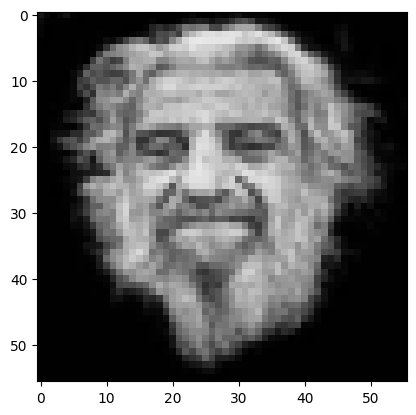

In [4]:
class MyDataset(Dataset):

    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images = [os.path.join(root_dir, image) for image in os.listdir(root_dir)]
        print(self.images[0])
        image = Image.open(self.images[3])
        image = image.resize((image_width, image_height))
        plt.imshow(image)
        plt.show()

    def __getitem__(self, index):
        image = Image.open(self.images[index])
        image = image.resize((image_width, image_height))
        #numpy_image = np.array(image)
        #image = torch.tensor(numpy_image) #.view(3, 28, 28)
        # Convert the image to grayscale
        grayscale_image = image.convert('L')
        numpy_image = np.array(grayscale_image)
        # Convert the image to a tensor
        tensor = torch.from_numpy(numpy_image)

        # Reshape the tensor
        tensor = tensor.view(1, *tensor.size())
        
        #print(tensor.shape)
        return tensor

    def __len__(self):
        return len(self.images)

dataset = MyDataset("./face")
loader = torch.utils.data.DataLoader(dataset, batch_size=10)


In [5]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

In [6]:
def show_first_batch(loader):
    for batch in loader:
        print(len(batch))
        print(batch.shape)
        show_images(batch, "Images in the first batch")
        break

10
torch.Size([10, 1, 56, 56])


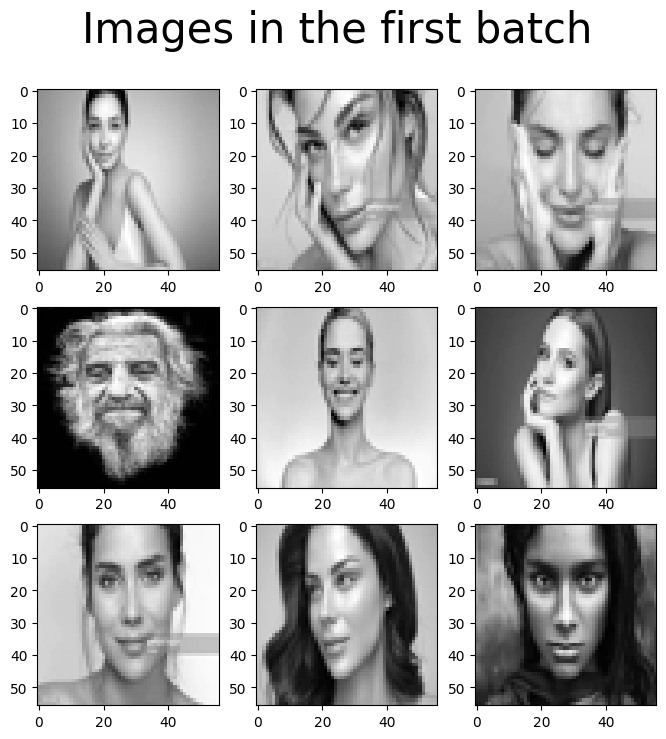

In [7]:
# Optionally, show a batch of regular images
show_first_batch(loader)

In [8]:
def show_first_batch(loader):
    for batch in loader:
        print(len(batch))
        print(batch[0].shape)
        
        show_images(batch, "Images in the first batch")
        #print(batch.shape)
        break

10
torch.Size([1, 56, 56])


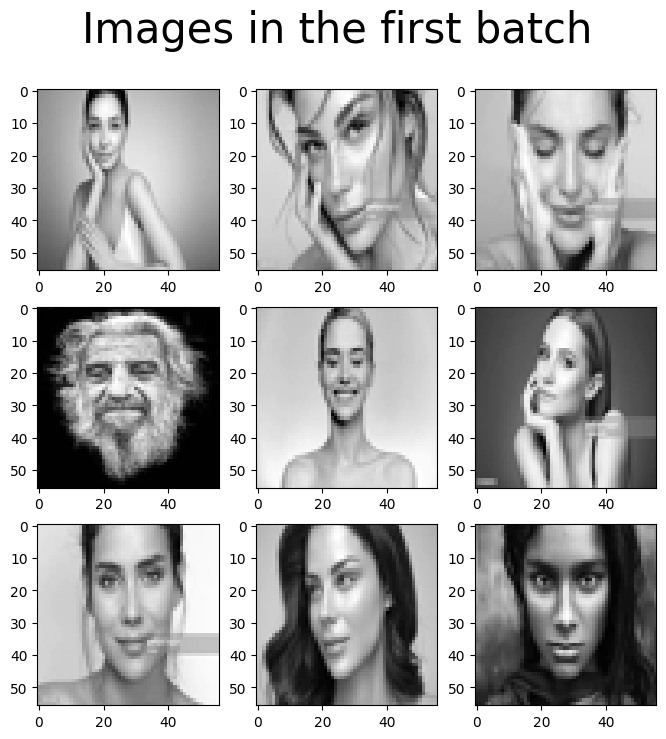

In [9]:
# Optionally, show a batch of regular images
show_first_batch(loader)

In [10]:
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cuda	NVIDIA GeForce GTX 1080 Ti


In [11]:
# DDPM class
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=1000, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(1, image_width, image_height)):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta * 30
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)

In [12]:
def show_forward(ddpm, loader, device):
    # Showing the forward process
    for batch in loader:
        imgs = batch

        show_images(imgs, "Original images")

        for percent in [0.20, 0.40, 0.60, 0.80, 1]:
            show_images(
                ddpm(imgs.to(device),
                     [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]),
                f"DDPM Noisy images {int(percent * 100)}%"
            )
        break

In [13]:
def generate_new_images(ddpm, n_samples=16, device=None, frames_per_gif=100, gif_name="sampling.gif", c=1, h=image_width, w=image_height):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        
        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z

            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                # Putting digits in range [0, 255]
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])

                # Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)

                # Rendering frame
                frames.append(frame)

    # Storing the gif
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            writer.append_data(frame)
            if idx == len(frames) - 1:
                for _ in range(frames_per_gif // 3):
                    writer.append_data(frames[-1])
    return x

In [14]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])

    return embedding

In [15]:
class MyBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

In [16]:
class MyUNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((1, 56, 56), 1, 10),
            MyBlock((10, 56, 56), 10, 10),
            MyBlock((10, 56, 56), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 28, 28), 10, 20),
            MyBlock((20, 28, 28), 20, 20),
            MyBlock((20, 28, 28), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 14, 14), 20, 40),
            MyBlock((40, 14, 14), 40, 40),
            MyBlock((40, 14, 14), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 6, 6), 40, 20),
            MyBlock((20, 6, 6), 20, 20),
            MyBlock((20, 6, 6), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 14, 14), 80, 40),
            MyBlock((40, 14, 14), 40, 20),
            MyBlock((20, 14, 14), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 28, 28), 40, 20),
            MyBlock((20, 28, 28), 20, 10),
            MyBlock((10, 28, 28), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 56, 56), 20, 10),
            MyBlock((10, 56, 56), 10, 10),
            MyBlock((10, 56, 56), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)
        #print(out_mid.shape)
        #print(out3.shape)
        #print(self.up1(out_mid).shape)
        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

In [29]:
# Defining model
n_steps, min_beta, max_beta = 1000, 0.0001, 0.02 # Originally used by the authors
ddpm = MyDDPM(MyUNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

ddpm.load_state_dict(torch.load("./ddpm_face.pt"))

In [30]:
sum([p.numel() for p in ddpm.parameters()])

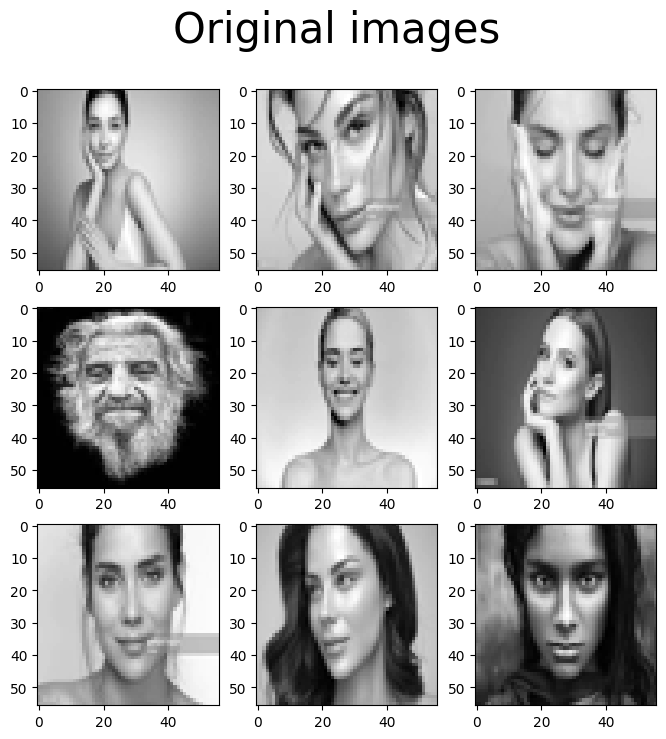

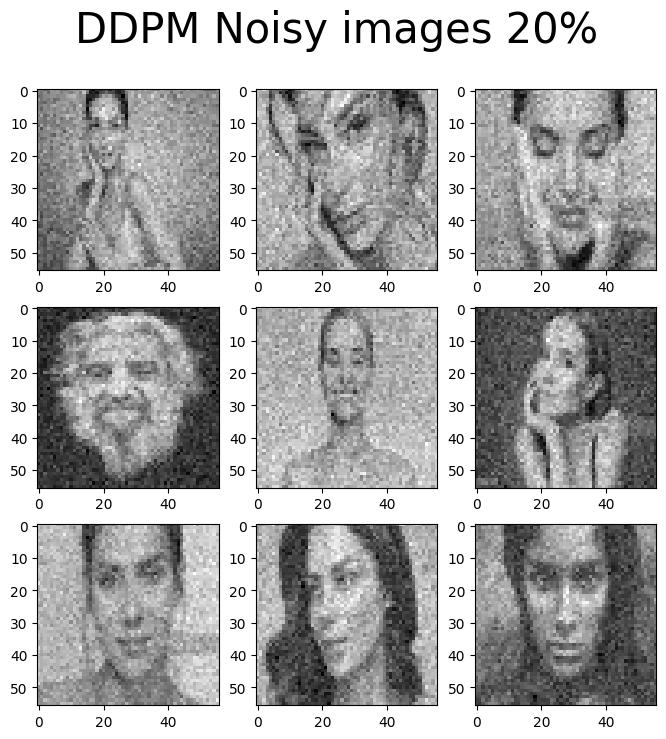

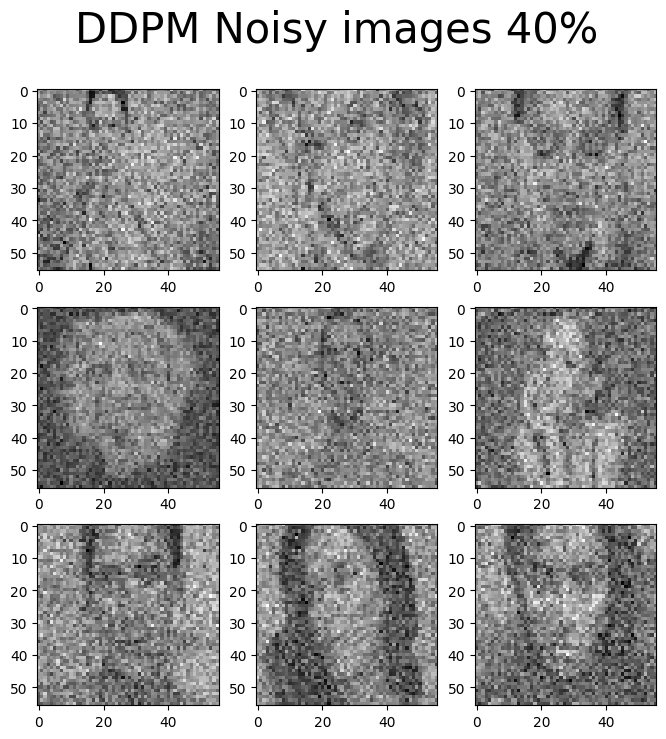

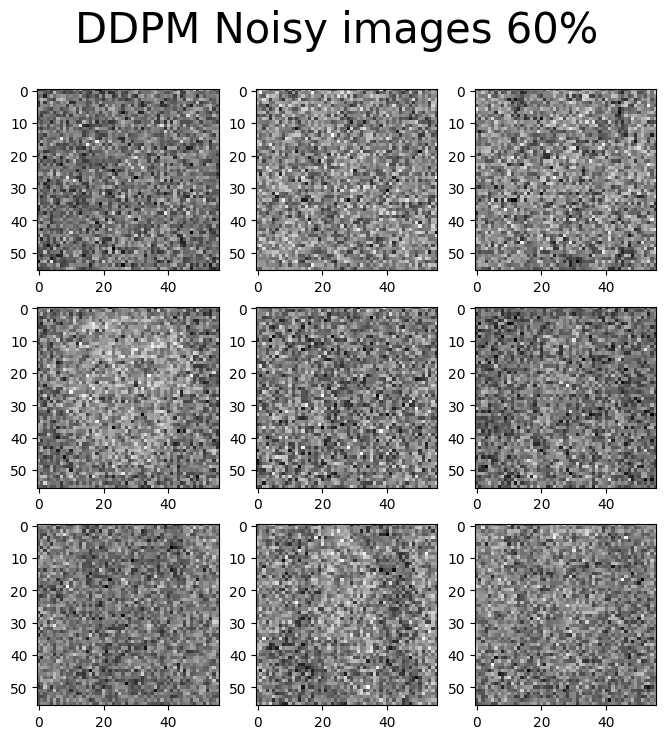

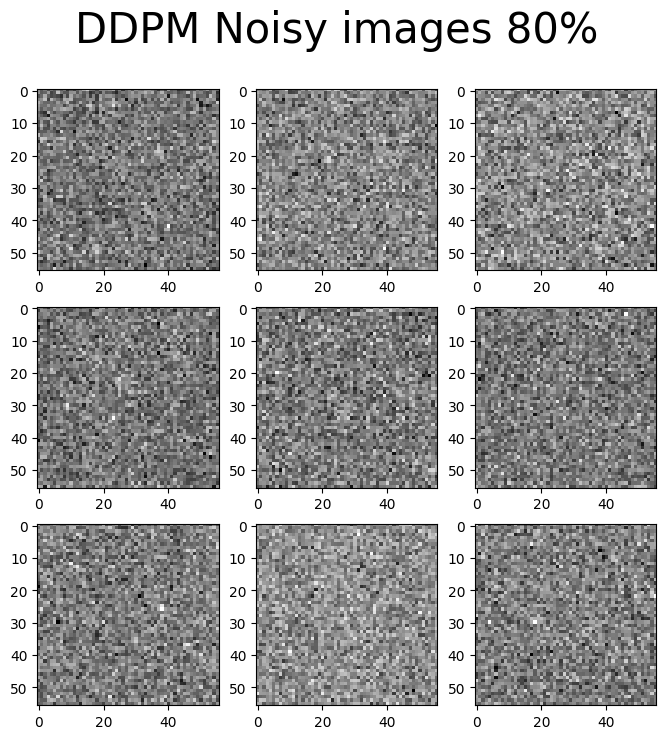

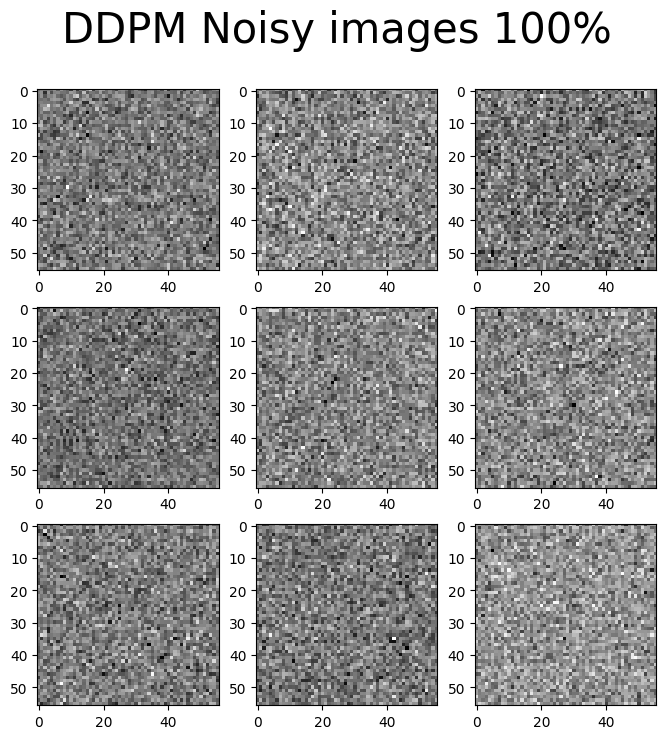

In [19]:
# Optionally, show the diffusion (forward) process
show_forward(ddpm, loader, device)

In [31]:
# Optionally, show the denoising (backward) process
generated = generate_new_images(ddpm, gif_name="before_training.gif")
show_images(generated, "Images generated before training")

In [21]:
def training_loop(ddpm, loader, n_epochs, optim, device, display=False, store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress"):
        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}")):
            # Loading data
            x0 = batch.to(device)
            n = len(x0)
            x0 = x0.float()
            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, eta)

            # Getting model estimation of noise based on the images and the time-step
            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            # Optimizing the MSE between the noise plugged and the predicted noise
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)

        # Display images generated at this epoch
        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.5f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)

In [22]:
# Training
store_path = "ddpm_face.pt" 
fashion = True
batch_size = 128
n_epochs = 10000
lr = 0.001
if not no_train:
    training_loop(ddpm, loader, n_epochs, optim=Adam(ddpm.parameters(), lr), device=device, store_path=store_path)

Training progress:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 1/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1: 0.99926 --> Best model ever (stored)


Epoch 2/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2: 0.99797 --> Best model ever (stored)


Epoch 3/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3: 1.00225


Epoch 4/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 4: 0.99673 --> Best model ever (stored)


Epoch 5/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 5: 0.99194 --> Best model ever (stored)


Epoch 6/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 6: 0.98238 --> Best model ever (stored)


Epoch 7/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 7: 0.99363


Epoch 8/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 8: 0.99099


Epoch 9/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 9: 0.97645 --> Best model ever (stored)


Epoch 10/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 10: 0.98450


Epoch 11/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 11: 0.96549 --> Best model ever (stored)


Epoch 12/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 12: 0.97345


Epoch 13/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 13: 0.94006 --> Best model ever (stored)


Epoch 14/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 14: 0.95104


Epoch 15/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 15: 0.94423


Epoch 16/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 16: 0.93252 --> Best model ever (stored)


Epoch 17/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 17: 0.91833 --> Best model ever (stored)


Epoch 18/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 18: 0.90678 --> Best model ever (stored)


Epoch 19/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 19: 0.87110 --> Best model ever (stored)


Epoch 20/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 20: 0.89807


Epoch 21/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 21: 0.85977 --> Best model ever (stored)


Epoch 22/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 22: 0.82805 --> Best model ever (stored)


Epoch 23/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 23: 0.82128 --> Best model ever (stored)


Epoch 24/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 24: 0.83558


Epoch 25/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 25: 0.81178 --> Best model ever (stored)


Epoch 26/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 26: 0.75178 --> Best model ever (stored)


Epoch 27/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 27: 0.77366


Epoch 28/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 28: 0.75469


Epoch 29/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 29: 0.67332 --> Best model ever (stored)


Epoch 30/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 30: 0.67384


Epoch 31/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 31: 0.67441


Epoch 32/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 32: 0.66785 --> Best model ever (stored)


Epoch 33/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 33: 0.60357 --> Best model ever (stored)


Epoch 34/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 34: 0.67046


Epoch 35/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 35: 0.60364


Epoch 36/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 36: 0.53919 --> Best model ever (stored)


Epoch 37/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 37: 0.52963 --> Best model ever (stored)


Epoch 38/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 38: 0.48248 --> Best model ever (stored)


Epoch 39/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 39: 0.55472


Epoch 40/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 40: 0.49215


Epoch 41/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 41: 0.50860


Epoch 42/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 42: 0.46361 --> Best model ever (stored)


Epoch 43/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 43: 0.39280 --> Best model ever (stored)


Epoch 44/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 44: 0.36126 --> Best model ever (stored)


Epoch 45/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 45: 0.38521


Epoch 46/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 46: 0.38428


Epoch 47/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 47: 0.37627


Epoch 48/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 48: 0.45947


Epoch 49/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 49: 0.32427 --> Best model ever (stored)


Epoch 50/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 50: 0.38043


Epoch 51/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 51: 0.33961


Epoch 52/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 52: 0.32084 --> Best model ever (stored)


Epoch 53/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 53: 0.39542


Epoch 54/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 54: 0.42085


Epoch 55/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 55: 0.31408 --> Best model ever (stored)


Epoch 56/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 56: 0.28546 --> Best model ever (stored)


Epoch 57/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 57: 0.34029


Epoch 58/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 58: 0.28524 --> Best model ever (stored)


Epoch 59/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 59: 0.27402 --> Best model ever (stored)


Epoch 60/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 60: 0.24035 --> Best model ever (stored)


Epoch 61/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 61: 0.24229


Epoch 62/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 62: 0.29269


Epoch 63/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 63: 0.32258


Epoch 64/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 64: 0.22847 --> Best model ever (stored)


Epoch 65/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 65: 0.19942 --> Best model ever (stored)


Epoch 66/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 66: 0.32632


Epoch 67/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 67: 0.35359


Epoch 68/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 68: 0.18834 --> Best model ever (stored)


Epoch 69/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 69: 0.21410


Epoch 70/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 70: 0.26470


Epoch 71/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 71: 0.33521


Epoch 72/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 72: 0.21073


Epoch 73/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 73: 0.19507


Epoch 74/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 74: 0.22466


Epoch 75/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 75: 0.28933


Epoch 76/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 76: 0.34725


Epoch 77/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 77: 0.40911


Epoch 78/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 78: 0.17850 --> Best model ever (stored)


Epoch 79/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 79: 0.20843


Epoch 80/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 80: 0.25273


Epoch 81/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 81: 0.27111


Epoch 82/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 82: 0.22615


Epoch 83/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 83: 0.18851


Epoch 84/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 84: 0.22126


Epoch 85/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 85: 0.23971


Epoch 86/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 86: 0.24132


Epoch 87/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 87: 0.26877


Epoch 88/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 88: 0.28242


Epoch 89/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 89: 0.18183


Epoch 90/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 90: 0.14716 --> Best model ever (stored)


Epoch 91/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 91: 0.36522


Epoch 92/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 92: 0.17162


Epoch 93/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 93: 0.25255


Epoch 94/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 94: 0.17262


Epoch 95/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 95: 0.35177


Epoch 96/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 96: 0.28512


Epoch 97/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 97: 0.15389


Epoch 98/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 98: 0.36762


Epoch 99/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 99: 0.16720


Epoch 100/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 100: 0.21117


Epoch 101/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 101: 0.16369


Epoch 102/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 102: 0.20328


Epoch 103/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 103: 0.15202


Epoch 104/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 104: 0.18503


Epoch 105/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 105: 0.11929 --> Best model ever (stored)


Epoch 106/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 106: 0.23641


Epoch 107/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 107: 0.25310


Epoch 108/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 108: 0.21860


Epoch 109/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 109: 0.15674


Epoch 110/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 110: 0.17959


Epoch 111/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 111: 0.18238


Epoch 112/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 112: 0.17311


Epoch 113/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 113: 0.15310


Epoch 114/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 114: 0.26618


Epoch 115/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 115: 0.13030


Epoch 116/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 116: 0.15286


Epoch 117/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 117: 0.16228


Epoch 118/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 118: 0.29616


Epoch 119/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 119: 0.17354


Epoch 120/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 120: 0.24514


Epoch 121/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 121: 0.18663


Epoch 122/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 122: 0.18122


Epoch 123/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 123: 0.20490


Epoch 124/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 124: 0.17971


Epoch 125/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 125: 0.20296


Epoch 126/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 126: 0.20912


Epoch 127/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 127: 0.23708


Epoch 128/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 128: 0.24820


Epoch 129/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 129: 0.14643


Epoch 130/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 130: 0.22443


Epoch 131/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 131: 0.31196


Epoch 132/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 132: 0.23928


Epoch 133/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 133: 0.12688


Epoch 134/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 134: 0.11290 --> Best model ever (stored)


Epoch 135/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 135: 0.11057 --> Best model ever (stored)


Epoch 136/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 136: 0.18544


Epoch 137/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 137: 0.14501


Epoch 138/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 138: 0.27011


Epoch 139/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 139: 0.28981


Epoch 140/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 140: 0.26327


Epoch 141/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 141: 0.13545


Epoch 142/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 142: 0.21383


Epoch 143/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 143: 0.20498


Epoch 144/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 144: 0.13805


Epoch 145/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 145: 0.12119


Epoch 146/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 146: 0.42236


Epoch 147/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 147: 0.24879


Epoch 148/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 148: 0.16892


Epoch 149/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 149: 0.24123


Epoch 150/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 150: 0.23650


Epoch 151/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 151: 0.14692


Epoch 152/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 152: 0.20222


Epoch 153/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 153: 0.21562


Epoch 154/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 154: 0.24042


Epoch 155/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 155: 0.27402


Epoch 156/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 156: 0.13552


Epoch 157/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 157: 0.19755


Epoch 158/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 158: 0.22415


Epoch 159/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 159: 0.12611


Epoch 160/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 160: 0.22653


Epoch 161/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 161: 0.13635


Epoch 162/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 162: 0.19124


Epoch 163/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 163: 0.23636


Epoch 164/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 164: 0.19579


Epoch 165/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 165: 0.15653


Epoch 166/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 166: 0.12819


Epoch 167/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 167: 0.16396


Epoch 168/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 168: 0.20753


Epoch 169/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 169: 0.13940


Epoch 170/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 170: 0.18085


Epoch 171/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 171: 0.22369


Epoch 172/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 172: 0.22066


Epoch 173/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 173: 0.21520


Epoch 174/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 174: 0.15534


Epoch 175/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 175: 0.27083


Epoch 176/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 176: 0.13398


Epoch 177/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 177: 0.14317


Epoch 178/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 178: 0.27401


Epoch 179/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 179: 0.09764 --> Best model ever (stored)


Epoch 180/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 180: 0.19277


Epoch 181/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 181: 0.15864


Epoch 182/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 182: 0.13402


Epoch 183/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 183: 0.23350


Epoch 184/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 184: 0.28637


Epoch 185/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 185: 0.09511 --> Best model ever (stored)


Epoch 186/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 186: 0.19718


Epoch 187/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 187: 0.14359


Epoch 188/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 188: 0.23279


Epoch 189/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 189: 0.23532


Epoch 190/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 190: 0.12426


Epoch 191/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 191: 0.18292


Epoch 192/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 192: 0.18866


Epoch 193/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 193: 0.13279


Epoch 194/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 194: 0.26298


Epoch 195/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 195: 0.15554


Epoch 196/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 196: 0.15856


Epoch 197/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 197: 0.29740


Epoch 198/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 198: 0.18052


Epoch 199/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 199: 0.10087


Epoch 200/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 200: 0.12797


Epoch 201/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 201: 0.12122


Epoch 202/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 202: 0.15526


Epoch 203/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 203: 0.16005


Epoch 204/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 204: 0.20491


Epoch 205/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 205: 0.11986


Epoch 206/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 206: 0.11656


Epoch 207/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 207: 0.25716


Epoch 208/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 208: 0.24124


Epoch 209/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 209: 0.14414


Epoch 210/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 210: 0.10691


Epoch 211/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 211: 0.25136


Epoch 212/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 212: 0.11819


Epoch 213/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 213: 0.13908


Epoch 214/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 214: 0.15257


Epoch 215/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 215: 0.16853


Epoch 216/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 216: 0.20922


Epoch 217/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 217: 0.11472


Epoch 218/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 218: 0.12114


Epoch 219/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 219: 0.14635


Epoch 220/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 220: 0.15249


Epoch 221/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 221: 0.10333


Epoch 222/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 222: 0.09783


Epoch 223/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 223: 0.30359


Epoch 224/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 224: 0.13881


Epoch 225/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 225: 0.09653


Epoch 226/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 226: 0.13201


Epoch 227/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 227: 0.24898


Epoch 228/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 228: 0.20937


Epoch 229/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 229: 0.13342


Epoch 230/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 230: 0.09409 --> Best model ever (stored)


Epoch 231/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 231: 0.16194


Epoch 232/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 232: 0.17777


Epoch 233/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 233: 0.19442


Epoch 234/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 234: 0.11769


Epoch 235/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 235: 0.18651


Epoch 236/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 236: 0.24121


Epoch 237/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 237: 0.17618


Epoch 238/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 238: 0.09997


Epoch 239/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 239: 0.09969


Epoch 240/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 240: 0.16188


Epoch 241/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 241: 0.12999


Epoch 242/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 242: 0.15935


Epoch 243/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 243: 0.13640


Epoch 244/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 244: 0.21694


Epoch 245/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 245: 0.16598


Epoch 246/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 246: 0.12010


Epoch 247/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 247: 0.13226


Epoch 248/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 248: 0.22404


Epoch 249/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 249: 0.17752


Epoch 250/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 250: 0.16529


Epoch 251/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 251: 0.10883


Epoch 252/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 252: 0.12973


Epoch 253/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 253: 0.16085


Epoch 254/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 254: 0.13640


Epoch 255/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 255: 0.11461


Epoch 256/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 256: 0.12067


Epoch 257/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 257: 0.23308


Epoch 258/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 258: 0.10565


Epoch 259/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 259: 0.13793


Epoch 260/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 260: 0.13450


Epoch 261/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 261: 0.14420


Epoch 262/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 262: 0.14345


Epoch 263/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 263: 0.11744


Epoch 264/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 264: 0.17419


Epoch 265/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 265: 0.12054


Epoch 266/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 266: 0.08412 --> Best model ever (stored)


Epoch 267/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 267: 0.12852


Epoch 268/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 268: 0.15530


Epoch 269/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 269: 0.14795


Epoch 270/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 270: 0.21860


Epoch 271/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 271: 0.19155


Epoch 272/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 272: 0.19970


Epoch 273/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 273: 0.22659


Epoch 274/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 274: 0.20035


Epoch 275/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 275: 0.11887


Epoch 276/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 276: 0.19768


Epoch 277/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 277: 0.12827


Epoch 278/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 278: 0.16137


Epoch 279/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 279: 0.14785


Epoch 280/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 280: 0.15591


Epoch 281/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 281: 0.10421


Epoch 282/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 282: 0.15761


Epoch 283/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 283: 0.17551


Epoch 284/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 284: 0.10562


Epoch 285/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 285: 0.16868


Epoch 286/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 286: 0.14327


Epoch 287/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 287: 0.14736


Epoch 288/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 288: 0.17631


Epoch 289/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 289: 0.13818


Epoch 290/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 290: 0.14032


Epoch 291/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 291: 0.15158


Epoch 292/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 292: 0.09528


Epoch 293/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 293: 0.08992


Epoch 294/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 294: 0.12058


Epoch 295/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 295: 0.14245


Epoch 296/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 296: 0.11460


Epoch 297/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 297: 0.17774


Epoch 298/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 298: 0.26992


Epoch 299/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 299: 0.16854


Epoch 300/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 300: 0.16725


Epoch 301/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 301: 0.21794


Epoch 302/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 302: 0.18732


Epoch 303/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 303: 0.13544


Epoch 304/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 304: 0.15068


Epoch 305/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 305: 0.19758


Epoch 306/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 306: 0.15530


Epoch 307/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 307: 0.09214


Epoch 308/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 308: 0.17854


Epoch 309/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 309: 0.21599


Epoch 310/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 310: 0.08303 --> Best model ever (stored)


Epoch 311/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 311: 0.10327


Epoch 312/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 312: 0.17376


Epoch 313/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 313: 0.21456


Epoch 314/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 314: 0.10634


Epoch 315/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 315: 0.12493


Epoch 316/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 316: 0.18708


Epoch 317/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 317: 0.13991


Epoch 318/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 318: 0.15458


Epoch 319/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 319: 0.11495


Epoch 320/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 320: 0.17850


Epoch 321/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 321: 0.09316


Epoch 322/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 322: 0.12309


Epoch 323/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 323: 0.23273


Epoch 324/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 324: 0.10818


Epoch 325/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 325: 0.11314


Epoch 326/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 326: 0.11749


Epoch 327/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 327: 0.13394


Epoch 328/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 328: 0.27435


Epoch 329/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 329: 0.17083


Epoch 330/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 330: 0.08556


Epoch 331/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 331: 0.18187


Epoch 332/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 332: 0.13012


Epoch 333/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 333: 0.09964


Epoch 334/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 334: 0.10280


Epoch 335/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 335: 0.23737


Epoch 336/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 336: 0.12492


Epoch 337/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 337: 0.15597


Epoch 338/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 338: 0.18823


Epoch 339/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 339: 0.15731


Epoch 340/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 340: 0.09620


Epoch 341/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 341: 0.15352


Epoch 342/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 342: 0.10220


Epoch 343/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 343: 0.10411


Epoch 344/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 344: 0.11239


Epoch 345/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 345: 0.23327


Epoch 346/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 346: 0.11412


Epoch 347/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 347: 0.27342


Epoch 348/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 348: 0.11986


Epoch 349/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 349: 0.11767


Epoch 350/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 350: 0.17277


Epoch 351/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 351: 0.12786


Epoch 352/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 352: 0.09887


Epoch 353/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 353: 0.09959


Epoch 354/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 354: 0.15098


Epoch 355/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 355: 0.13175


Epoch 356/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 356: 0.23329


Epoch 357/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 357: 0.10213


Epoch 358/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 358: 0.14626


Epoch 359/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 359: 0.12350


Epoch 360/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 360: 0.13487


Epoch 361/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 361: 0.20547


Epoch 362/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 362: 0.13871


Epoch 363/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 363: 0.07079 --> Best model ever (stored)


Epoch 364/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 364: 0.15334


Epoch 365/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 365: 0.10496


Epoch 366/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 366: 0.14471


Epoch 367/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 367: 0.15421


Epoch 368/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 368: 0.13944


Epoch 369/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 369: 0.15723


Epoch 370/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 370: 0.09309


Epoch 371/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 371: 0.11569


Epoch 372/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 372: 0.18199


Epoch 373/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 373: 0.24921


Epoch 374/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 374: 0.11475


Epoch 375/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 375: 0.16569


Epoch 376/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 376: 0.10854


Epoch 377/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 377: 0.18951


Epoch 378/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 378: 0.19485


Epoch 379/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 379: 0.18328


Epoch 380/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 380: 0.20193


Epoch 381/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 381: 0.09506


Epoch 382/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 382: 0.10331


Epoch 383/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 383: 0.07672


Epoch 384/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 384: 0.17203


Epoch 385/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 385: 0.12885


Epoch 386/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 386: 0.11250


Epoch 387/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 387: 0.16286


Epoch 388/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 388: 0.14631


Epoch 389/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 389: 0.08360


Epoch 390/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 390: 0.15935


Epoch 391/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 391: 0.18893


Epoch 392/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 392: 0.14892


Epoch 393/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 393: 0.12783


Epoch 394/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 394: 0.09716


Epoch 395/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 395: 0.11079


Epoch 396/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 396: 0.15029


Epoch 397/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 397: 0.16937


Epoch 398/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 398: 0.14630


Epoch 399/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 399: 0.09431


Epoch 400/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 400: 0.11217


Epoch 401/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 401: 0.07761


Epoch 402/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 402: 0.25301


Epoch 403/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 403: 0.11195


Epoch 404/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 404: 0.12496


Epoch 405/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 405: 0.07611


Epoch 406/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 406: 0.18171


Epoch 407/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 407: 0.30912


Epoch 408/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 408: 0.24671


Epoch 409/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 409: 0.10766


Epoch 410/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 410: 0.14342


Epoch 411/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 411: 0.15561


Epoch 412/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 412: 0.07548


Epoch 413/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 413: 0.21779


Epoch 414/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 414: 0.09024


Epoch 415/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 415: 0.09691


Epoch 416/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 416: 0.10079


Epoch 417/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 417: 0.07364


Epoch 418/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 418: 0.24632


Epoch 419/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 419: 0.18610


Epoch 420/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 420: 0.15084


Epoch 421/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 421: 0.09121


Epoch 422/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 422: 0.17462


Epoch 423/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 423: 0.15697


Epoch 424/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 424: 0.12638


Epoch 425/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 425: 0.15836


Epoch 426/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 426: 0.10000


Epoch 427/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 427: 0.15535


Epoch 428/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 428: 0.13417


Epoch 429/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 429: 0.14171


Epoch 430/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 430: 0.10426


Epoch 431/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 431: 0.16388


Epoch 432/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 432: 0.08902


Epoch 433/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 433: 0.17492


Epoch 434/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 434: 0.13171


Epoch 435/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 435: 0.09406


Epoch 436/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 436: 0.11151


Epoch 437/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 437: 0.15872


Epoch 438/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 438: 0.19711


Epoch 439/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 439: 0.16637


Epoch 440/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 440: 0.14603


Epoch 441/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 441: 0.08781


Epoch 442/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 442: 0.15670


Epoch 443/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 443: 0.09056


Epoch 444/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 444: 0.09094


Epoch 445/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 445: 0.10320


Epoch 446/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 446: 0.08806


Epoch 447/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 447: 0.11347


Epoch 448/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 448: 0.12196


Epoch 449/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 449: 0.12403


Epoch 450/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 450: 0.16846


Epoch 451/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 451: 0.11507


Epoch 452/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 452: 0.09340


Epoch 453/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 453: 0.11249


Epoch 454/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 454: 0.11010


Epoch 455/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 455: 0.11648


Epoch 456/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 456: 0.09830


Epoch 457/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 457: 0.12170


Epoch 458/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 458: 0.23739


Epoch 459/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 459: 0.08428


Epoch 460/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 460: 0.12490


Epoch 461/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 461: 0.10992


Epoch 462/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 462: 0.12198


Epoch 463/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 463: 0.11838


Epoch 464/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 464: 0.09654


Epoch 465/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 465: 0.16785


Epoch 466/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 466: 0.19500


Epoch 467/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 467: 0.23675


Epoch 468/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 468: 0.07854


Epoch 469/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 469: 0.25759


Epoch 470/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 470: 0.11031


Epoch 471/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 471: 0.09679


Epoch 472/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 472: 0.11161


Epoch 473/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 473: 0.13140


Epoch 474/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 474: 0.16225


Epoch 475/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 475: 0.12827


Epoch 476/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 476: 0.19917


Epoch 477/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 477: 0.26695


Epoch 478/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 478: 0.07903


Epoch 479/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 479: 0.08542


Epoch 480/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 480: 0.12221


Epoch 481/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 481: 0.09017


Epoch 482/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 482: 0.15091


Epoch 483/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 483: 0.11716


Epoch 484/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 484: 0.20303


Epoch 485/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 485: 0.06536 --> Best model ever (stored)


Epoch 486/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 486: 0.20866


Epoch 487/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 487: 0.07460


Epoch 488/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 488: 0.08485


Epoch 489/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 489: 0.14140


Epoch 490/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 490: 0.07520


Epoch 491/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 491: 0.14856


Epoch 492/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 492: 0.12256


Epoch 493/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 493: 0.09472


Epoch 494/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 494: 0.08673


Epoch 495/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 495: 0.22851


Epoch 496/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 496: 0.12981


Epoch 497/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 497: 0.10914


Epoch 498/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 498: 0.06737


Epoch 499/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 499: 0.13791


Epoch 500/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 500: 0.13831


Epoch 501/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 501: 0.08881


Epoch 502/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 502: 0.12965


Epoch 503/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 503: 0.08527


Epoch 504/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 504: 0.13430


Epoch 505/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 505: 0.12972


Epoch 506/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 506: 0.21433


Epoch 507/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 507: 0.20686


Epoch 508/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 508: 0.12938


Epoch 509/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 509: 0.18323


Epoch 510/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 510: 0.11257


Epoch 511/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 511: 0.12315


Epoch 512/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 512: 0.12912


Epoch 513/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 513: 0.10174


Epoch 514/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 514: 0.13453


Epoch 515/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 515: 0.08343


Epoch 516/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 516: 0.10231


Epoch 517/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 517: 0.05767 --> Best model ever (stored)


Epoch 518/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 518: 0.07289


Epoch 519/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 519: 0.17044


Epoch 520/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 520: 0.22044


Epoch 521/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 521: 0.09624


Epoch 522/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 522: 0.15549


Epoch 523/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 523: 0.08516


Epoch 524/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 524: 0.07456


Epoch 525/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 525: 0.12833


Epoch 526/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 526: 0.20651


Epoch 527/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 527: 0.09565


Epoch 528/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 528: 0.04606 --> Best model ever (stored)


Epoch 529/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 529: 0.13212


Epoch 530/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 530: 0.21199


Epoch 531/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 531: 0.23423


Epoch 532/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 532: 0.12622


Epoch 533/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 533: 0.11539


Epoch 534/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 534: 0.07156


Epoch 535/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 535: 0.20404


Epoch 536/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 536: 0.09360


Epoch 537/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 537: 0.14355


Epoch 538/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 538: 0.23876


Epoch 539/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 539: 0.08028


Epoch 540/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 540: 0.08991


Epoch 541/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 541: 0.15627


Epoch 542/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 542: 0.10603


Epoch 543/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 543: 0.16118


Epoch 544/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 544: 0.11744


Epoch 545/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 545: 0.08704


Epoch 546/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 546: 0.07083


Epoch 547/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 547: 0.09928


Epoch 548/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 548: 0.12279


Epoch 549/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 549: 0.27139


Epoch 550/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 550: 0.10684


Epoch 551/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 551: 0.10008


Epoch 552/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 552: 0.10706


Epoch 553/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 553: 0.11447


Epoch 554/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 554: 0.16464


Epoch 555/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 555: 0.08951


Epoch 556/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 556: 0.16128


Epoch 557/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 557: 0.11938


Epoch 558/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 558: 0.11681


Epoch 559/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 559: 0.10058


Epoch 560/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 560: 0.07470


Epoch 561/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 561: 0.12322


Epoch 562/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 562: 0.06398


Epoch 563/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 563: 0.13607


Epoch 564/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 564: 0.10500


Epoch 565/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 565: 0.07019


Epoch 566/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 566: 0.10722


Epoch 567/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 567: 0.11920


Epoch 568/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 568: 0.13028


Epoch 569/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 569: 0.22218


Epoch 570/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 570: 0.18511


Epoch 571/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 571: 0.13025


Epoch 572/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 572: 0.22090


Epoch 573/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 573: 0.11107


Epoch 574/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 574: 0.15215


Epoch 575/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 575: 0.09266


Epoch 576/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 576: 0.14157


Epoch 577/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 577: 0.12667


Epoch 578/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 578: 0.14517


Epoch 579/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 579: 0.13862


Epoch 580/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 580: 0.06124


Epoch 581/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 581: 0.08188


Epoch 582/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 582: 0.15978


Epoch 583/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 583: 0.07985


Epoch 584/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 584: 0.19117


Epoch 585/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 585: 0.21953


Epoch 586/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 586: 0.06041


Epoch 587/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 587: 0.13827


Epoch 588/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 588: 0.11460


Epoch 589/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 589: 0.15345


Epoch 590/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 590: 0.21717


Epoch 591/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 591: 0.21036


Epoch 592/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 592: 0.10031


Epoch 593/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 593: 0.12424


Epoch 594/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 594: 0.20913


Epoch 595/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 595: 0.08261


Epoch 596/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 596: 0.13500


Epoch 597/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 597: 0.09946


Epoch 598/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 598: 0.07592


Epoch 599/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 599: 0.07546


Epoch 600/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 600: 0.10114


Epoch 601/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 601: 0.10477


Epoch 602/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 602: 0.14575


Epoch 603/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 603: 0.11010


Epoch 604/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 604: 0.07710


Epoch 605/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 605: 0.08215


Epoch 606/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 606: 0.05294


Epoch 607/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 607: 0.08655


Epoch 608/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 608: 0.09243


Epoch 609/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 609: 0.06265


Epoch 610/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 610: 0.15193


Epoch 611/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 611: 0.12503


Epoch 612/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 612: 0.09318


Epoch 613/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 613: 0.11386


Epoch 614/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 614: 0.16098


Epoch 615/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 615: 0.18881


Epoch 616/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 616: 0.14222


Epoch 617/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 617: 0.11100


Epoch 618/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 618: 0.07653


Epoch 619/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 619: 0.08076


Epoch 620/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 620: 0.11460


Epoch 621/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 621: 0.07583


Epoch 622/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 622: 0.06526


Epoch 623/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 623: 0.07085


Epoch 624/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 624: 0.15770


Epoch 625/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 625: 0.04917


Epoch 626/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 626: 0.11670


Epoch 627/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 627: 0.08138


Epoch 628/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 628: 0.10094


Epoch 629/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 629: 0.16404


Epoch 630/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 630: 0.16985


Epoch 631/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 631: 0.15460


Epoch 632/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 632: 0.07944


Epoch 633/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 633: 0.15231


Epoch 634/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 634: 0.07178


Epoch 635/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 635: 0.07214


Epoch 636/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 636: 0.21115


Epoch 637/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 637: 0.09501


Epoch 638/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 638: 0.20531


Epoch 639/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 639: 0.14174


Epoch 640/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 640: 0.06643


Epoch 641/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 641: 0.08156


Epoch 642/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 642: 0.12411


Epoch 643/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 643: 0.11890


Epoch 644/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 644: 0.18554


Epoch 645/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 645: 0.07844


Epoch 646/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 646: 0.08181


Epoch 647/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 647: 0.18842


Epoch 648/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 648: 0.07249


Epoch 649/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 649: 0.14289


Epoch 650/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 650: 0.17647


Epoch 651/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 651: 0.16350


Epoch 652/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 652: 0.11649


Epoch 653/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 653: 0.12433


Epoch 654/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 654: 0.07882


Epoch 655/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 655: 0.31614


Epoch 656/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 656: 0.13473


Epoch 657/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 657: 0.20063


Epoch 658/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 658: 0.12134


Epoch 659/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 659: 0.07312


Epoch 660/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 660: 0.11950


Epoch 661/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 661: 0.04494 --> Best model ever (stored)


Epoch 662/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 662: 0.09612


Epoch 663/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 663: 0.08590


Epoch 664/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 664: 0.08410


Epoch 665/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 665: 0.12744


Epoch 666/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 666: 0.05755


Epoch 667/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 667: 0.20744


Epoch 668/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 668: 0.15557


Epoch 669/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 669: 0.13971


Epoch 670/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 670: 0.13323


Epoch 671/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 671: 0.10581


Epoch 672/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 672: 0.08254


Epoch 673/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 673: 0.07685


Epoch 674/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 674: 0.05763


Epoch 675/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 675: 0.06057


Epoch 676/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 676: 0.08216


Epoch 677/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 677: 0.13201


Epoch 678/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 678: 0.10680


Epoch 679/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 679: 0.14064


Epoch 680/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 680: 0.21563


Epoch 681/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 681: 0.18102


Epoch 682/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 682: 0.13663


Epoch 683/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 683: 0.07189


Epoch 684/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 684: 0.20499


Epoch 685/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 685: 0.08246


Epoch 686/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 686: 0.07109


Epoch 687/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 687: 0.10520


Epoch 688/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 688: 0.08930


Epoch 689/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 689: 0.13861


Epoch 690/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 690: 0.16645


Epoch 691/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 691: 0.22670


Epoch 692/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 692: 0.14118


Epoch 693/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 693: 0.09657


Epoch 694/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 694: 0.13993


Epoch 695/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 695: 0.06383


Epoch 696/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 696: 0.10345


Epoch 697/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 697: 0.11258


Epoch 698/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 698: 0.08035


Epoch 699/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 699: 0.07205


Epoch 700/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 700: 0.06212


Epoch 701/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 701: 0.17677


Epoch 702/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 702: 0.07338


Epoch 703/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 703: 0.07412


Epoch 704/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 704: 0.24090


Epoch 705/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 705: 0.09816


Epoch 706/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 706: 0.07053


Epoch 707/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 707: 0.06865


Epoch 708/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 708: 0.11015


Epoch 709/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 709: 0.09995


Epoch 710/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 710: 0.07918


Epoch 711/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 711: 0.18253


Epoch 712/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 712: 0.20365


Epoch 713/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 713: 0.15591


Epoch 714/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 714: 0.08101


Epoch 715/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 715: 0.07819


Epoch 716/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 716: 0.08570


Epoch 717/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 717: 0.07939


Epoch 718/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 718: 0.16501


Epoch 719/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 719: 0.05099


Epoch 720/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 720: 0.15757


Epoch 721/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 721: 0.05387


Epoch 722/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 722: 0.13477


Epoch 723/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 723: 0.11658


Epoch 724/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 724: 0.08183


Epoch 725/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 725: 0.12073


Epoch 726/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 726: 0.05717


Epoch 727/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 727: 0.13402


Epoch 728/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 728: 0.14008


Epoch 729/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 729: 0.08613


Epoch 730/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 730: 0.06281


Epoch 731/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 731: 0.06445


Epoch 732/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 732: 0.09282


Epoch 733/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 733: 0.14805


Epoch 734/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 734: 0.06528


Epoch 735/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 735: 0.10736


Epoch 736/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 736: 0.07654


Epoch 737/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 737: 0.09114


Epoch 738/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 738: 0.22524


Epoch 739/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 739: 0.08600


Epoch 740/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 740: 0.13296


Epoch 741/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 741: 0.05725


Epoch 742/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 742: 0.11462


Epoch 743/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 743: 0.04700


Epoch 744/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 744: 0.16551


Epoch 745/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 745: 0.04990


Epoch 746/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 746: 0.11845


Epoch 747/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 747: 0.11212


Epoch 748/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 748: 0.07269


Epoch 749/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 749: 0.08553


Epoch 750/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 750: 0.12784


Epoch 751/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 751: 0.06038


Epoch 752/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 752: 0.10617


Epoch 753/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 753: 0.06525


Epoch 754/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 754: 0.04595


Epoch 755/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 755: 0.20570


Epoch 756/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 756: 0.15833


Epoch 757/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 757: 0.11851


Epoch 758/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 758: 0.05068


Epoch 759/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 759: 0.10644


Epoch 760/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 760: 0.07647


Epoch 761/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 761: 0.09854


Epoch 762/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 762: 0.12738


Epoch 763/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 763: 0.06344


Epoch 764/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 764: 0.09190


Epoch 765/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 765: 0.19500


Epoch 766/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 766: 0.14000


Epoch 767/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 767: 0.14966


Epoch 768/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 768: 0.13218


Epoch 769/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 769: 0.16082


Epoch 770/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 770: 0.06033


Epoch 771/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 771: 0.15423


Epoch 772/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 772: 0.08721


Epoch 773/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 773: 0.06023


Epoch 774/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 774: 0.07892


Epoch 775/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 775: 0.07083


Epoch 776/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 776: 0.08010


Epoch 777/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 777: 0.08460


Epoch 778/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 778: 0.04949


Epoch 779/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 779: 0.11251


Epoch 780/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 780: 0.06324


Epoch 781/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 781: 0.12135


Epoch 782/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 782: 0.07038


Epoch 783/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 783: 0.08220


Epoch 784/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 784: 0.10096


Epoch 785/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 785: 0.03227 --> Best model ever (stored)


Epoch 786/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 786: 0.07568


Epoch 787/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 787: 0.09619


Epoch 788/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 788: 0.10867


Epoch 789/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 789: 0.12746


Epoch 790/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 790: 0.10907


Epoch 791/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 791: 0.07094


Epoch 792/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 792: 0.04830


Epoch 793/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 793: 0.06325


Epoch 794/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 794: 0.13199


Epoch 795/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 795: 0.05249


Epoch 796/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 796: 0.06620


Epoch 797/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 797: 0.14508


Epoch 798/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 798: 0.13868


Epoch 799/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 799: 0.18002


Epoch 800/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 800: 0.08926


Epoch 801/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 801: 0.07602


Epoch 802/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 802: 0.11606


Epoch 803/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 803: 0.09821


Epoch 804/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 804: 0.05935


Epoch 805/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 805: 0.06578


Epoch 806/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 806: 0.07022


Epoch 807/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 807: 0.15339


Epoch 808/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 808: 0.06979


Epoch 809/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 809: 0.09467


Epoch 810/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 810: 0.06771


Epoch 811/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 811: 0.07819


Epoch 812/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 812: 0.14170


Epoch 813/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 813: 0.07664


Epoch 814/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 814: 0.06436


Epoch 815/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 815: 0.03717


Epoch 816/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 816: 0.06569


Epoch 817/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 817: 0.05435


Epoch 818/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 818: 0.06283


Epoch 819/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 819: 0.06816


Epoch 820/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 820: 0.11517


Epoch 821/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 821: 0.11430


Epoch 822/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 822: 0.10813


Epoch 823/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 823: 0.18341


Epoch 824/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 824: 0.09267


Epoch 825/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 825: 0.11199


Epoch 826/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 826: 0.14066


Epoch 827/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 827: 0.19989


Epoch 828/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 828: 0.08124


Epoch 829/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 829: 0.09965


Epoch 830/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 830: 0.10226


Epoch 831/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 831: 0.08835


Epoch 832/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 832: 0.09587


Epoch 833/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 833: 0.16257


Epoch 834/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 834: 0.03292


Epoch 835/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 835: 0.08296


Epoch 836/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 836: 0.16068


Epoch 837/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 837: 0.07017


Epoch 838/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 838: 0.06237


Epoch 839/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 839: 0.04797


Epoch 840/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 840: 0.21750


Epoch 841/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 841: 0.05962


Epoch 842/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 842: 0.08372


Epoch 843/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 843: 0.10559


Epoch 844/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 844: 0.13192


Epoch 845/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 845: 0.11620


Epoch 846/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 846: 0.06957


Epoch 847/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 847: 0.09381


Epoch 848/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 848: 0.12241


Epoch 849/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 849: 0.18043


Epoch 850/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 850: 0.12419


Epoch 851/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 851: 0.12409


Epoch 852/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 852: 0.14805


Epoch 853/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 853: 0.08962


Epoch 854/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 854: 0.13147


Epoch 855/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 855: 0.07006


Epoch 856/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 856: 0.11623


Epoch 857/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 857: 0.06463


Epoch 858/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 858: 0.11136


Epoch 859/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 859: 0.05034


Epoch 860/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 860: 0.10986


Epoch 861/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 861: 0.10386


Epoch 862/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 862: 0.10992


Epoch 863/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 863: 0.06533


Epoch 864/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 864: 0.13951


Epoch 865/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 865: 0.06728


Epoch 866/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 866: 0.11635


Epoch 867/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 867: 0.11665


Epoch 868/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 868: 0.16430


Epoch 869/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 869: 0.06275


Epoch 870/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 870: 0.08279


Epoch 871/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 871: 0.05324


Epoch 872/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 872: 0.07364


Epoch 873/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 873: 0.07867


Epoch 874/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 874: 0.07693


Epoch 875/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 875: 0.09057


Epoch 876/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 876: 0.03686


Epoch 877/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 877: 0.09886


Epoch 878/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 878: 0.06186


Epoch 879/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 879: 0.06586


Epoch 880/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 880: 0.07564


Epoch 881/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 881: 0.22590


Epoch 882/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 882: 0.07167


Epoch 883/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 883: 0.09575


Epoch 884/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 884: 0.08093


Epoch 885/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 885: 0.09138


Epoch 886/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 886: 0.06288


Epoch 887/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 887: 0.06474


Epoch 888/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 888: 0.07371


Epoch 889/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 889: 0.10154


Epoch 890/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 890: 0.07174


Epoch 891/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 891: 0.09878


Epoch 892/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 892: 0.04665


Epoch 893/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 893: 0.17986


Epoch 894/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 894: 0.08825


Epoch 895/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 895: 0.06081


Epoch 896/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 896: 0.05836


Epoch 897/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 897: 0.08656


Epoch 898/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 898: 0.06440


Epoch 899/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 899: 0.15205


Epoch 900/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 900: 0.06777


Epoch 901/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 901: 0.04511


Epoch 902/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 902: 0.10727


Epoch 903/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 903: 0.07827


Epoch 904/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 904: 0.11552


Epoch 905/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 905: 0.16428


Epoch 906/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 906: 0.08617


Epoch 907/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 907: 0.06960


Epoch 908/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 908: 0.10486


Epoch 909/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 909: 0.09302


Epoch 910/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 910: 0.05492


Epoch 911/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 911: 0.15080


Epoch 912/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 912: 0.16110


Epoch 913/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 913: 0.12256


Epoch 914/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 914: 0.07207


Epoch 915/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 915: 0.09950


Epoch 916/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 916: 0.04766


Epoch 917/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 917: 0.09822


Epoch 918/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 918: 0.11215


Epoch 919/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 919: 0.08962


Epoch 920/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 920: 0.07701


Epoch 921/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 921: 0.10074


Epoch 922/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 922: 0.08740


Epoch 923/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 923: 0.03481


Epoch 924/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 924: 0.16089


Epoch 925/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 925: 0.09964


Epoch 926/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 926: 0.15110


Epoch 927/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 927: 0.06608


Epoch 928/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 928: 0.12262


Epoch 929/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 929: 0.15199


Epoch 930/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 930: 0.15538


Epoch 931/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 931: 0.06637


Epoch 932/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 932: 0.07079


Epoch 933/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 933: 0.03335


Epoch 934/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 934: 0.16719


Epoch 935/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 935: 0.05508


Epoch 936/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 936: 0.11394


Epoch 937/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 937: 0.10485


Epoch 938/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 938: 0.06339


Epoch 939/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 939: 0.07309


Epoch 940/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 940: 0.08327


Epoch 941/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 941: 0.15105


Epoch 942/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 942: 0.06222


Epoch 943/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 943: 0.06475


Epoch 944/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 944: 0.10554


Epoch 945/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 945: 0.07005


Epoch 946/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 946: 0.08334


Epoch 947/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 947: 0.13780


Epoch 948/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 948: 0.12653


Epoch 949/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 949: 0.11745


Epoch 950/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 950: 0.05929


Epoch 951/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 951: 0.06777


Epoch 952/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 952: 0.06718


Epoch 953/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 953: 0.11129


Epoch 954/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 954: 0.09379


Epoch 955/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 955: 0.13210


Epoch 956/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 956: 0.13447


Epoch 957/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 957: 0.12112


Epoch 958/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 958: 0.07275


Epoch 959/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 959: 0.07623


Epoch 960/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 960: 0.16081


Epoch 961/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 961: 0.14536


Epoch 962/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 962: 0.07914


Epoch 963/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 963: 0.10011


Epoch 964/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 964: 0.05706


Epoch 965/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 965: 0.10905


Epoch 966/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 966: 0.03952


Epoch 967/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 967: 0.07468


Epoch 968/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 968: 0.12205


Epoch 969/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 969: 0.04466


Epoch 970/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 970: 0.08380


Epoch 971/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 971: 0.05080


Epoch 972/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 972: 0.05965


Epoch 973/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 973: 0.07093


Epoch 974/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 974: 0.10617


Epoch 975/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 975: 0.08357


Epoch 976/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 976: 0.09087


Epoch 977/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 977: 0.08301


Epoch 978/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 978: 0.04426


Epoch 979/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 979: 0.10829


Epoch 980/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 980: 0.05344


Epoch 981/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 981: 0.06303


Epoch 982/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 982: 0.16209


Epoch 983/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 983: 0.10058


Epoch 984/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 984: 0.08479


Epoch 985/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 985: 0.08164


Epoch 986/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 986: 0.14946


Epoch 987/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 987: 0.08769


Epoch 988/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 988: 0.12186


Epoch 989/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 989: 0.08823


Epoch 990/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 990: 0.11246


Epoch 991/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 991: 0.04888


Epoch 992/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 992: 0.13000


Epoch 993/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 993: 0.09226


Epoch 994/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 994: 0.06880


Epoch 995/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 995: 0.10750


Epoch 996/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 996: 0.09915


Epoch 997/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 997: 0.05926


Epoch 998/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 998: 0.12859


Epoch 999/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 999: 0.11490


Epoch 1000/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1000: 0.03388


Epoch 1001/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1001: 0.04867


Epoch 1002/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1002: 0.07039


Epoch 1003/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1003: 0.04524


Epoch 1004/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1004: 0.06172


Epoch 1005/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1005: 0.07376


Epoch 1006/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1006: 0.05204


Epoch 1007/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1007: 0.09546


Epoch 1008/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1008: 0.10701


Epoch 1009/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1009: 0.04407


Epoch 1010/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1010: 0.18999


Epoch 1011/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1011: 0.08883


Epoch 1012/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1012: 0.11475


Epoch 1013/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1013: 0.07454


Epoch 1014/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1014: 0.07721


Epoch 1015/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1015: 0.08038


Epoch 1016/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1016: 0.05868


Epoch 1017/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1017: 0.13864


Epoch 1018/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1018: 0.08584


Epoch 1019/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1019: 0.03809


Epoch 1020/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1020: 0.07231


Epoch 1021/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1021: 0.09201


Epoch 1022/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1022: 0.07361


Epoch 1023/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1023: 0.06997


Epoch 1024/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1024: 0.08589


Epoch 1025/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1025: 0.07028


Epoch 1026/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1026: 0.12135


Epoch 1027/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1027: 0.07269


Epoch 1028/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1028: 0.09606


Epoch 1029/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1029: 0.10034


Epoch 1030/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1030: 0.08719


Epoch 1031/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1031: 0.04279


Epoch 1032/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1032: 0.04085


Epoch 1033/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1033: 0.07611


Epoch 1034/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1034: 0.03661


Epoch 1035/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1035: 0.09437


Epoch 1036/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1036: 0.08662


Epoch 1037/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1037: 0.03980


Epoch 1038/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1038: 0.17510


Epoch 1039/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1039: 0.06233


Epoch 1040/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1040: 0.10616


Epoch 1041/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1041: 0.03481


Epoch 1042/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1042: 0.12084


Epoch 1043/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1043: 0.03818


Epoch 1044/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1044: 0.06760


Epoch 1045/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1045: 0.05563


Epoch 1046/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1046: 0.03612


Epoch 1047/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1047: 0.12630


Epoch 1048/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1048: 0.15762


Epoch 1049/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1049: 0.07667


Epoch 1050/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1050: 0.07988


Epoch 1051/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1051: 0.16291


Epoch 1052/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1052: 0.04281


Epoch 1053/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1053: 0.14133


Epoch 1054/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1054: 0.10247


Epoch 1055/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1055: 0.09232


Epoch 1056/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1056: 0.12117


Epoch 1057/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1057: 0.03868


Epoch 1058/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1058: 0.04834


Epoch 1059/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1059: 0.10819


Epoch 1060/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1060: 0.16399


Epoch 1061/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1061: 0.06502


Epoch 1062/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1062: 0.07298


Epoch 1063/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1063: 0.13664


Epoch 1064/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1064: 0.04381


Epoch 1065/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1065: 0.06583


Epoch 1066/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1066: 0.06686


Epoch 1067/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1067: 0.04003


Epoch 1068/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1068: 0.15685


Epoch 1069/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1069: 0.14898


Epoch 1070/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1070: 0.11223


Epoch 1071/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1071: 0.06926


Epoch 1072/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1072: 0.06432


Epoch 1073/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1073: 0.06526


Epoch 1074/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1074: 0.05890


Epoch 1075/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1075: 0.10281


Epoch 1076/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1076: 0.07941


Epoch 1077/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1077: 0.03660


Epoch 1078/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1078: 0.06055


Epoch 1079/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1079: 0.05547


Epoch 1080/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1080: 0.06092


Epoch 1081/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1081: 0.09255


Epoch 1082/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1082: 0.04905


Epoch 1083/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1083: 0.11412


Epoch 1084/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1084: 0.04172


Epoch 1085/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1085: 0.06434


Epoch 1086/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1086: 0.08078


Epoch 1087/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1087: 0.10514


Epoch 1088/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1088: 0.11931


Epoch 1089/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1089: 0.08507


Epoch 1090/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1090: 0.14086


Epoch 1091/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1091: 0.06615


Epoch 1092/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1092: 0.17306


Epoch 1093/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1093: 0.10964


Epoch 1094/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1094: 0.10998


Epoch 1095/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1095: 0.06853


Epoch 1096/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1096: 0.07476


Epoch 1097/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1097: 0.08024


Epoch 1098/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1098: 0.07951


Epoch 1099/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1099: 0.15810


Epoch 1100/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1100: 0.15165


Epoch 1101/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1101: 0.04320


Epoch 1102/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1102: 0.10893


Epoch 1103/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1103: 0.09063


Epoch 1104/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1104: 0.08895


Epoch 1105/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1105: 0.05881


Epoch 1106/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1106: 0.10179


Epoch 1107/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1107: 0.08575


Epoch 1108/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1108: 0.13210


Epoch 1109/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1109: 0.09283


Epoch 1110/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1110: 0.06900


Epoch 1111/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1111: 0.10647


Epoch 1112/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1112: 0.07397


Epoch 1113/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1113: 0.10701


Epoch 1114/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1114: 0.11576


Epoch 1115/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1115: 0.13997


Epoch 1116/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1116: 0.11554


Epoch 1117/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1117: 0.08692


Epoch 1118/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1118: 0.09593


Epoch 1119/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1119: 0.06868


Epoch 1120/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1120: 0.04656


Epoch 1121/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1121: 0.05056


Epoch 1122/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1122: 0.07314


Epoch 1123/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1123: 0.05872


Epoch 1124/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1124: 0.03775


Epoch 1125/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1125: 0.09281


Epoch 1126/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1126: 0.08235


Epoch 1127/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1127: 0.08080


Epoch 1128/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1128: 0.04602


Epoch 1129/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1129: 0.04834


Epoch 1130/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1130: 0.04330


Epoch 1131/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1131: 0.11145


Epoch 1132/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1132: 0.04605


Epoch 1133/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1133: 0.06126


Epoch 1134/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1134: 0.06603


Epoch 1135/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1135: 0.03959


Epoch 1136/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1136: 0.06948


Epoch 1137/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1137: 0.10631


Epoch 1138/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1138: 0.06407


Epoch 1139/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1139: 0.06082


Epoch 1140/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1140: 0.05159


Epoch 1141/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1141: 0.05157


Epoch 1142/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1142: 0.04703


Epoch 1143/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1143: 0.06348


Epoch 1144/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1144: 0.09949


Epoch 1145/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1145: 0.04449


Epoch 1146/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1146: 0.08910


Epoch 1147/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1147: 0.15928


Epoch 1148/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1148: 0.06052


Epoch 1149/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1149: 0.06665


Epoch 1150/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1150: 0.06555


Epoch 1151/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1151: 0.07413


Epoch 1152/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1152: 0.10565


Epoch 1153/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1153: 0.06502


Epoch 1154/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1154: 0.08085


Epoch 1155/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1155: 0.11749


Epoch 1156/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1156: 0.06790


Epoch 1157/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1157: 0.07941


Epoch 1158/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1158: 0.10241


Epoch 1159/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1159: 0.15092


Epoch 1160/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1160: 0.08311


Epoch 1161/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1161: 0.08182


Epoch 1162/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1162: 0.11266


Epoch 1163/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1163: 0.10802


Epoch 1164/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1164: 0.05797


Epoch 1165/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1165: 0.14997


Epoch 1166/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1166: 0.05321


Epoch 1167/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1167: 0.04544


Epoch 1168/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1168: 0.05276


Epoch 1169/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1169: 0.05124


Epoch 1170/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1170: 0.06695


Epoch 1171/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1171: 0.14281


Epoch 1172/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1172: 0.13032


Epoch 1173/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1173: 0.07458


Epoch 1174/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1174: 0.06465


Epoch 1175/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1175: 0.08945


Epoch 1176/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1176: 0.19900


Epoch 1177/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1177: 0.06631


Epoch 1178/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1178: 0.06020


Epoch 1179/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1179: 0.07161


Epoch 1180/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1180: 0.05282


Epoch 1181/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1181: 0.09656


Epoch 1182/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1182: 0.07469


Epoch 1183/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1183: 0.15941


Epoch 1184/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1184: 0.06278


Epoch 1185/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1185: 0.07346


Epoch 1186/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1186: 0.03114 --> Best model ever (stored)


Epoch 1187/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1187: 0.04629


Epoch 1188/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1188: 0.06228


Epoch 1189/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1189: 0.15888


Epoch 1190/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1190: 0.09185


Epoch 1191/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1191: 0.08581


Epoch 1192/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1192: 0.13848


Epoch 1193/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1193: 0.11920


Epoch 1194/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1194: 0.09345


Epoch 1195/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1195: 0.17265


Epoch 1196/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1196: 0.08895


Epoch 1197/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1197: 0.21608


Epoch 1198/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1198: 0.08118


Epoch 1199/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1199: 0.06235


Epoch 1200/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1200: 0.05033


Epoch 1201/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1201: 0.10171


Epoch 1202/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1202: 0.05618


Epoch 1203/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1203: 0.04376


Epoch 1204/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1204: 0.09972


Epoch 1205/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1205: 0.06593


Epoch 1206/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1206: 0.14608


Epoch 1207/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1207: 0.02523 --> Best model ever (stored)


Epoch 1208/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1208: 0.07434


Epoch 1209/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1209: 0.06699


Epoch 1210/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1210: 0.15242


Epoch 1211/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1211: 0.06155


Epoch 1212/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1212: 0.07683


Epoch 1213/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1213: 0.07627


Epoch 1214/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1214: 0.13948


Epoch 1215/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1215: 0.03413


Epoch 1216/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1216: 0.02828


Epoch 1217/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1217: 0.10716


Epoch 1218/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1218: 0.17377


Epoch 1219/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1219: 0.05571


Epoch 1220/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1220: 0.05357


Epoch 1221/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1221: 0.05492


Epoch 1222/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1222: 0.06462


Epoch 1223/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1223: 0.06925


Epoch 1224/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1224: 0.05702


Epoch 1225/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1225: 0.07200


Epoch 1226/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1226: 0.09999


Epoch 1227/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1227: 0.05848


Epoch 1228/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1228: 0.08262


Epoch 1229/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1229: 0.04334


Epoch 1230/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1230: 0.10817


Epoch 1231/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1231: 0.09180


Epoch 1232/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1232: 0.07343


Epoch 1233/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1233: 0.08109


Epoch 1234/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1234: 0.08960


Epoch 1235/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1235: 0.08511


Epoch 1236/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1236: 0.06293


Epoch 1237/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1237: 0.06748


Epoch 1238/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1238: 0.08573


Epoch 1239/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1239: 0.10594


Epoch 1240/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1240: 0.09897


Epoch 1241/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1241: 0.08661


Epoch 1242/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1242: 0.08847


Epoch 1243/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1243: 0.07202


Epoch 1244/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1244: 0.06399


Epoch 1245/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1245: 0.19290


Epoch 1246/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1246: 0.06962


Epoch 1247/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1247: 0.06143


Epoch 1248/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1248: 0.04335


Epoch 1249/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1249: 0.08236


Epoch 1250/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1250: 0.04333


Epoch 1251/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1251: 0.05636


Epoch 1252/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1252: 0.08068


Epoch 1253/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1253: 0.08497


Epoch 1254/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1254: 0.03053


Epoch 1255/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1255: 0.05422


Epoch 1256/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1256: 0.09216


Epoch 1257/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1257: 0.05014


Epoch 1258/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1258: 0.05500


Epoch 1259/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1259: 0.07692


Epoch 1260/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1260: 0.06449


Epoch 1261/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1261: 0.05505


Epoch 1262/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1262: 0.06107


Epoch 1263/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1263: 0.06525


Epoch 1264/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1264: 0.07100


Epoch 1265/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1265: 0.07635


Epoch 1266/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1266: 0.08060


Epoch 1267/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1267: 0.05716


Epoch 1268/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1268: 0.07556


Epoch 1269/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1269: 0.08339


Epoch 1270/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1270: 0.06947


Epoch 1271/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1271: 0.11493


Epoch 1272/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1272: 0.08282


Epoch 1273/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1273: 0.08968


Epoch 1274/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1274: 0.03721


Epoch 1275/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1275: 0.10084


Epoch 1276/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1276: 0.06242


Epoch 1277/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1277: 0.11582


Epoch 1278/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1278: 0.06993


Epoch 1279/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1279: 0.06361


Epoch 1280/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1280: 0.04838


Epoch 1281/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1281: 0.13156


Epoch 1282/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1282: 0.05835


Epoch 1283/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1283: 0.08214


Epoch 1284/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1284: 0.06819


Epoch 1285/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1285: 0.02952


Epoch 1286/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1286: 0.14083


Epoch 1287/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1287: 0.06142


Epoch 1288/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1288: 0.09792


Epoch 1289/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1289: 0.14600


Epoch 1290/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1290: 0.05586


Epoch 1291/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1291: 0.09091


Epoch 1292/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1292: 0.03767


Epoch 1293/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1293: 0.08694


Epoch 1294/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1294: 0.05332


Epoch 1295/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1295: 0.04509


Epoch 1296/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1296: 0.04842


Epoch 1297/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1297: 0.15773


Epoch 1298/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1298: 0.04679


Epoch 1299/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1299: 0.08976


Epoch 1300/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1300: 0.04510


Epoch 1301/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1301: 0.07627


Epoch 1302/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1302: 0.11459


Epoch 1303/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1303: 0.07486


Epoch 1304/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1304: 0.08222


Epoch 1305/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1305: 0.13057


Epoch 1306/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1306: 0.08642


Epoch 1307/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1307: 0.14617


Epoch 1308/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1308: 0.04296


Epoch 1309/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1309: 0.12431


Epoch 1310/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1310: 0.08492


Epoch 1311/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1311: 0.05858


Epoch 1312/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1312: 0.09464


Epoch 1313/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1313: 0.06095


Epoch 1314/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1314: 0.03599


Epoch 1315/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1315: 0.07369


Epoch 1316/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1316: 0.11191


Epoch 1317/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1317: 0.04273


Epoch 1318/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1318: 0.08092


Epoch 1319/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1319: 0.17994


Epoch 1320/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1320: 0.03772


Epoch 1321/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1321: 0.04788


Epoch 1322/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1322: 0.04312


Epoch 1323/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1323: 0.07270


Epoch 1324/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1324: 0.07468


Epoch 1325/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1325: 0.06350


Epoch 1326/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1326: 0.13105


Epoch 1327/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1327: 0.11475


Epoch 1328/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1328: 0.08141


Epoch 1329/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1329: 0.06162


Epoch 1330/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1330: 0.14870


Epoch 1331/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1331: 0.09212


Epoch 1332/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1332: 0.04079


Epoch 1333/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1333: 0.06712


Epoch 1334/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1334: 0.09879


Epoch 1335/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1335: 0.20571


Epoch 1336/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1336: 0.04819


Epoch 1337/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1337: 0.09602


Epoch 1338/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1338: 0.06448


Epoch 1339/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1339: 0.03923


Epoch 1340/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1340: 0.12820


Epoch 1341/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1341: 0.03812


Epoch 1342/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1342: 0.07448


Epoch 1343/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1343: 0.10804


Epoch 1344/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1344: 0.12868


Epoch 1345/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1345: 0.05248


Epoch 1346/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1346: 0.05709


Epoch 1347/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1347: 0.18530


Epoch 1348/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1348: 0.05382


Epoch 1349/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1349: 0.04073


Epoch 1350/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1350: 0.12025


Epoch 1351/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1351: 0.05924


Epoch 1352/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1352: 0.04085


Epoch 1353/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1353: 0.05050


Epoch 1354/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1354: 0.04796


Epoch 1355/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1355: 0.08633


Epoch 1356/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1356: 0.16022


Epoch 1357/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1357: 0.06829


Epoch 1358/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1358: 0.04075


Epoch 1359/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1359: 0.08968


Epoch 1360/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1360: 0.07937


Epoch 1361/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1361: 0.12385


Epoch 1362/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1362: 0.04482


Epoch 1363/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1363: 0.03505


Epoch 1364/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1364: 0.05497


Epoch 1365/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1365: 0.04654


Epoch 1366/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1366: 0.19112


Epoch 1367/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1367: 0.08716


Epoch 1368/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1368: 0.06043


Epoch 1369/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1369: 0.03536


Epoch 1370/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1370: 0.03105


Epoch 1371/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1371: 0.18118


Epoch 1372/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1372: 0.05366


Epoch 1373/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1373: 0.03503


Epoch 1374/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1374: 0.08161


Epoch 1375/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1375: 0.05583


Epoch 1376/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1376: 0.10712


Epoch 1377/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1377: 0.04471


Epoch 1378/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1378: 0.07544


Epoch 1379/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1379: 0.08070


Epoch 1380/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1380: 0.04108


Epoch 1381/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1381: 0.03750


Epoch 1382/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1382: 0.05488


Epoch 1383/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1383: 0.08471


Epoch 1384/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1384: 0.05384


Epoch 1385/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1385: 0.08534


Epoch 1386/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1386: 0.06592


Epoch 1387/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1387: 0.05004


Epoch 1388/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1388: 0.04435


Epoch 1389/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1389: 0.06377


Epoch 1390/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1390: 0.05039


Epoch 1391/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1391: 0.13108


Epoch 1392/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1392: 0.05857


Epoch 1393/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1393: 0.06403


Epoch 1394/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1394: 0.12663


Epoch 1395/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1395: 0.13065


Epoch 1396/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1396: 0.08130


Epoch 1397/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1397: 0.05109


Epoch 1398/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1398: 0.08159


Epoch 1399/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1399: 0.08569


Epoch 1400/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1400: 0.06404


Epoch 1401/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1401: 0.04949


Epoch 1402/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1402: 0.07255


Epoch 1403/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1403: 0.04531


Epoch 1404/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1404: 0.06936


Epoch 1405/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1405: 0.02512 --> Best model ever (stored)


Epoch 1406/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1406: 0.07833


Epoch 1407/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1407: 0.10924


Epoch 1408/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1408: 0.10393


Epoch 1409/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1409: 0.03552


Epoch 1410/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1410: 0.07837


Epoch 1411/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1411: 0.11189


Epoch 1412/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1412: 0.04530


Epoch 1413/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1413: 0.07294


Epoch 1414/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1414: 0.07735


Epoch 1415/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1415: 0.05527


Epoch 1416/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1416: 0.06131


Epoch 1417/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1417: 0.05341


Epoch 1418/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1418: 0.03982


Epoch 1419/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1419: 0.06582


Epoch 1420/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1420: 0.06224


Epoch 1421/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1421: 0.06692


Epoch 1422/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1422: 0.08068


Epoch 1423/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1423: 0.02780


Epoch 1424/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1424: 0.03871


Epoch 1425/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1425: 0.04737


Epoch 1426/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1426: 0.07434


Epoch 1427/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1427: 0.03783


Epoch 1428/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1428: 0.07193


Epoch 1429/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1429: 0.13538


Epoch 1430/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1430: 0.05452


Epoch 1431/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1431: 0.08183


Epoch 1432/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1432: 0.21412


Epoch 1433/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1433: 0.04101


Epoch 1434/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1434: 0.07503


Epoch 1435/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1435: 0.11181


Epoch 1436/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1436: 0.02946


Epoch 1437/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1437: 0.18937


Epoch 1438/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1438: 0.12050


Epoch 1439/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1439: 0.05591


Epoch 1440/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1440: 0.08855


Epoch 1441/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1441: 0.04959


Epoch 1442/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1442: 0.07078


Epoch 1443/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1443: 0.06306


Epoch 1444/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1444: 0.08890


Epoch 1445/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1445: 0.07034


Epoch 1446/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1446: 0.06092


Epoch 1447/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1447: 0.07268


Epoch 1448/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1448: 0.07918


Epoch 1449/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1449: 0.08174


Epoch 1450/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1450: 0.07843


Epoch 1451/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1451: 0.08707


Epoch 1452/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1452: 0.11022


Epoch 1453/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1453: 0.14047


Epoch 1454/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1454: 0.05304


Epoch 1455/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1455: 0.02716


Epoch 1456/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1456: 0.08722


Epoch 1457/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1457: 0.05005


Epoch 1458/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1458: 0.07450


Epoch 1459/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1459: 0.11062


Epoch 1460/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1460: 0.05504


Epoch 1461/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1461: 0.04736


Epoch 1462/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1462: 0.06960


Epoch 1463/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1463: 0.05329


Epoch 1464/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1464: 0.10775


Epoch 1465/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1465: 0.04466


Epoch 1466/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1466: 0.06547


Epoch 1467/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1467: 0.18222


Epoch 1468/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1468: 0.05198


Epoch 1469/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1469: 0.04247


Epoch 1470/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1470: 0.07151


Epoch 1471/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1471: 0.07437


Epoch 1472/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1472: 0.06648


Epoch 1473/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1473: 0.06681


Epoch 1474/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1474: 0.08639


Epoch 1475/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1475: 0.13385


Epoch 1476/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1476: 0.06152


Epoch 1477/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1477: 0.12138


Epoch 1478/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1478: 0.04749


Epoch 1479/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1479: 0.05654


Epoch 1480/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1480: 0.05623


Epoch 1481/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1481: 0.03938


Epoch 1482/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1482: 0.10121


Epoch 1483/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1483: 0.06622


Epoch 1484/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1484: 0.05692


Epoch 1485/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1485: 0.06607


Epoch 1486/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1486: 0.04356


Epoch 1487/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1487: 0.05247


Epoch 1488/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1488: 0.10965


Epoch 1489/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1489: 0.04522


Epoch 1490/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1490: 0.05964


Epoch 1491/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1491: 0.07397


Epoch 1492/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1492: 0.09954


Epoch 1493/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1493: 0.06584


Epoch 1494/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1494: 0.03479


Epoch 1495/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1495: 0.06889


Epoch 1496/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1496: 0.08375


Epoch 1497/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1497: 0.06060


Epoch 1498/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1498: 0.07255


Epoch 1499/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1499: 0.05803


Epoch 1500/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1500: 0.08458


Epoch 1501/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1501: 0.18542


Epoch 1502/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1502: 0.05820


Epoch 1503/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1503: 0.03463


Epoch 1504/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1504: 0.08735


Epoch 1505/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1505: 0.08110


Epoch 1506/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1506: 0.04661


Epoch 1507/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1507: 0.03192


Epoch 1508/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1508: 0.06189


Epoch 1509/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1509: 0.06798


Epoch 1510/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1510: 0.03342


Epoch 1511/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1511: 0.06606


Epoch 1512/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1512: 0.11307


Epoch 1513/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1513: 0.06978


Epoch 1514/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1514: 0.06644


Epoch 1515/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1515: 0.07577


Epoch 1516/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1516: 0.06257


Epoch 1517/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1517: 0.07840


Epoch 1518/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1518: 0.09024


Epoch 1519/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1519: 0.08940


Epoch 1520/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1520: 0.08980


Epoch 1521/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1521: 0.10608


Epoch 1522/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1522: 0.08873


Epoch 1523/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1523: 0.06532


Epoch 1524/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1524: 0.03180


Epoch 1525/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1525: 0.08707


Epoch 1526/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1526: 0.09519


Epoch 1527/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1527: 0.05990


Epoch 1528/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1528: 0.03810


Epoch 1529/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1529: 0.23905


Epoch 1530/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1530: 0.04134


Epoch 1531/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1531: 0.03994


Epoch 1532/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1532: 0.08365


Epoch 1533/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1533: 0.07317


Epoch 1534/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1534: 0.05566


Epoch 1535/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1535: 0.12457


Epoch 1536/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1536: 0.09264


Epoch 1537/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1537: 0.05690


Epoch 1538/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1538: 0.07143


Epoch 1539/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1539: 0.11271


Epoch 1540/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1540: 0.07288


Epoch 1541/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1541: 0.03415


Epoch 1542/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1542: 0.04110


Epoch 1543/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1543: 0.04715


Epoch 1544/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1544: 0.06489


Epoch 1545/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1545: 0.05619


Epoch 1546/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1546: 0.05312


Epoch 1547/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1547: 0.06836


Epoch 1548/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1548: 0.05868


Epoch 1549/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1549: 0.03911


Epoch 1550/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1550: 0.08369


Epoch 1551/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1551: 0.07469


Epoch 1552/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1552: 0.17003


Epoch 1553/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1553: 0.07013


Epoch 1554/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1554: 0.06834


Epoch 1555/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1555: 0.04676


Epoch 1556/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1556: 0.05203


Epoch 1557/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1557: 0.07177


Epoch 1558/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1558: 0.07464


Epoch 1559/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1559: 0.09235


Epoch 1560/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1560: 0.03897


Epoch 1561/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1561: 0.08078


Epoch 1562/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1562: 0.05574


Epoch 1563/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1563: 0.04590


Epoch 1564/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1564: 0.07067


Epoch 1565/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1565: 0.06519


Epoch 1566/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1566: 0.06153


Epoch 1567/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1567: 0.07502


Epoch 1568/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1568: 0.04314


Epoch 1569/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1569: 0.05721


Epoch 1570/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1570: 0.10494


Epoch 1571/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1571: 0.08627


Epoch 1572/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1572: 0.03868


Epoch 1573/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1573: 0.04140


Epoch 1574/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1574: 0.03299


Epoch 1575/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1575: 0.03067


Epoch 1576/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1576: 0.06915


Epoch 1577/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1577: 0.07593


Epoch 1578/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1578: 0.05311


Epoch 1579/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1579: 0.05200


Epoch 1580/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1580: 0.05428


Epoch 1581/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1581: 0.12864


Epoch 1582/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1582: 0.13833


Epoch 1583/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1583: 0.08445


Epoch 1584/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1584: 0.03724


Epoch 1585/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1585: 0.04442


Epoch 1586/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1586: 0.11280


Epoch 1587/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1587: 0.06160


Epoch 1588/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1588: 0.07554


Epoch 1589/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1589: 0.05588


Epoch 1590/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1590: 0.05756


Epoch 1591/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1591: 0.04864


Epoch 1592/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1592: 0.05237


Epoch 1593/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1593: 0.06184


Epoch 1594/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1594: 0.03073


Epoch 1595/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1595: 0.04791


Epoch 1596/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1596: 0.05317


Epoch 1597/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1597: 0.08032


Epoch 1598/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1598: 0.06231


Epoch 1599/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1599: 0.06316


Epoch 1600/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1600: 0.13793


Epoch 1601/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1601: 0.11077


Epoch 1602/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1602: 0.04877


Epoch 1603/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1603: 0.12035


Epoch 1604/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1604: 0.05562


Epoch 1605/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1605: 0.05845


Epoch 1606/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1606: 0.05292


Epoch 1607/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1607: 0.15426


Epoch 1608/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1608: 0.06261


Epoch 1609/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1609: 0.07931


Epoch 1610/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1610: 0.07793


Epoch 1611/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1611: 0.03372


Epoch 1612/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1612: 0.08025


Epoch 1613/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1613: 0.03390


Epoch 1614/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1614: 0.04809


Epoch 1615/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1615: 0.04954


Epoch 1616/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1616: 0.12350


Epoch 1617/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1617: 0.03857


Epoch 1618/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1618: 0.07682


Epoch 1619/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1619: 0.05253


Epoch 1620/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1620: 0.12860


Epoch 1621/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1621: 0.07321


Epoch 1622/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1622: 0.05235


Epoch 1623/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1623: 0.05904


Epoch 1624/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1624: 0.07497


Epoch 1625/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1625: 0.11157


Epoch 1626/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1626: 0.04184


Epoch 1627/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1627: 0.08303


Epoch 1628/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1628: 0.06436


Epoch 1629/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1629: 0.08674


Epoch 1630/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1630: 0.07784


Epoch 1631/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1631: 0.04406


Epoch 1632/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1632: 0.04361


Epoch 1633/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1633: 0.05436


Epoch 1634/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1634: 0.07679


Epoch 1635/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1635: 0.05799


Epoch 1636/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1636: 0.03843


Epoch 1637/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1637: 0.04468


Epoch 1638/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1638: 0.06739


Epoch 1639/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1639: 0.08580


Epoch 1640/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1640: 0.06684


Epoch 1641/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1641: 0.08319


Epoch 1642/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1642: 0.03358


Epoch 1643/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1643: 0.07657


Epoch 1644/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1644: 0.05603


Epoch 1645/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1645: 0.02483 --> Best model ever (stored)


Epoch 1646/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1646: 0.07774


Epoch 1647/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1647: 0.04628


Epoch 1648/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1648: 0.09590


Epoch 1649/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1649: 0.03181


Epoch 1650/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1650: 0.05964


Epoch 1651/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1651: 0.10147


Epoch 1652/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1652: 0.06894


Epoch 1653/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1653: 0.05731


Epoch 1654/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1654: 0.08238


Epoch 1655/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1655: 0.06587


Epoch 1656/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1656: 0.14637


Epoch 1657/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1657: 0.07467


Epoch 1658/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1658: 0.06640


Epoch 1659/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1659: 0.07331


Epoch 1660/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1660: 0.06413


Epoch 1661/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1661: 0.07363


Epoch 1662/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1662: 0.05636


Epoch 1663/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1663: 0.10255


Epoch 1664/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1664: 0.04561


Epoch 1665/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1665: 0.07103


Epoch 1666/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1666: 0.06454


Epoch 1667/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1667: 0.04752


Epoch 1668/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1668: 0.09711


Epoch 1669/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1669: 0.12870


Epoch 1670/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1670: 0.07476


Epoch 1671/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1671: 0.08018


Epoch 1672/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1672: 0.11280


Epoch 1673/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1673: 0.11742


Epoch 1674/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1674: 0.05295


Epoch 1675/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1675: 0.06995


Epoch 1676/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1676: 0.11184


Epoch 1677/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1677: 0.06738


Epoch 1678/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1678: 0.04525


Epoch 1679/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1679: 0.07458


Epoch 1680/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1680: 0.06603


Epoch 1681/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1681: 0.08346


Epoch 1682/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1682: 0.05053


Epoch 1683/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1683: 0.04809


Epoch 1684/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1684: 0.04012


Epoch 1685/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1685: 0.06532


Epoch 1686/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1686: 0.06184


Epoch 1687/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1687: 0.06139


Epoch 1688/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1688: 0.09326


Epoch 1689/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1689: 0.10285


Epoch 1690/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1690: 0.03802


Epoch 1691/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1691: 0.06321


Epoch 1692/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1692: 0.05718


Epoch 1693/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1693: 0.10439


Epoch 1694/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1694: 0.04603


Epoch 1695/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1695: 0.02436 --> Best model ever (stored)


Epoch 1696/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1696: 0.04029


Epoch 1697/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1697: 0.08799


Epoch 1698/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1698: 0.13560


Epoch 1699/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1699: 0.09052


Epoch 1700/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1700: 0.05608


Epoch 1701/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1701: 0.05685


Epoch 1702/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1702: 0.10742


Epoch 1703/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1703: 0.07081


Epoch 1704/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1704: 0.06626


Epoch 1705/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1705: 0.07723


Epoch 1706/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1706: 0.03063


Epoch 1707/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1707: 0.04727


Epoch 1708/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1708: 0.04781


Epoch 1709/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1709: 0.06460


Epoch 1710/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1710: 0.05538


Epoch 1711/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1711: 0.11071


Epoch 1712/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1712: 0.11933


Epoch 1713/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1713: 0.04642


Epoch 1714/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1714: 0.15138


Epoch 1715/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1715: 0.06197


Epoch 1716/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1716: 0.15517


Epoch 1717/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1717: 0.06081


Epoch 1718/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1718: 0.04527


Epoch 1719/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1719: 0.10163


Epoch 1720/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1720: 0.06681


Epoch 1721/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1721: 0.09534


Epoch 1722/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1722: 0.15044


Epoch 1723/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1723: 0.04711


Epoch 1724/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1724: 0.11222


Epoch 1725/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1725: 0.05840


Epoch 1726/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1726: 0.12850


Epoch 1727/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1727: 0.10689


Epoch 1728/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1728: 0.09223


Epoch 1729/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1729: 0.07075


Epoch 1730/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1730: 0.05527


Epoch 1731/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1731: 0.09447


Epoch 1732/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1732: 0.05891


Epoch 1733/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1733: 0.09536


Epoch 1734/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1734: 0.03040


Epoch 1735/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1735: 0.11615


Epoch 1736/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1736: 0.03458


Epoch 1737/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1737: 0.03690


Epoch 1738/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1738: 0.05482


Epoch 1739/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1739: 0.14165


Epoch 1740/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1740: 0.06624


Epoch 1741/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1741: 0.05447


Epoch 1742/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1742: 0.04201


Epoch 1743/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1743: 0.06024


Epoch 1744/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1744: 0.09776


Epoch 1745/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1745: 0.07623


Epoch 1746/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1746: 0.05253


Epoch 1747/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1747: 0.07514


Epoch 1748/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1748: 0.06752


Epoch 1749/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1749: 0.12963


Epoch 1750/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1750: 0.06272


Epoch 1751/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1751: 0.04787


Epoch 1752/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1752: 0.04822


Epoch 1753/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1753: 0.11548


Epoch 1754/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1754: 0.05263


Epoch 1755/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1755: 0.03967


Epoch 1756/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1756: 0.03884


Epoch 1757/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1757: 0.06767


Epoch 1758/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1758: 0.07104


Epoch 1759/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1759: 0.07925


Epoch 1760/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1760: 0.07734


Epoch 1761/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1761: 0.03261


Epoch 1762/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1762: 0.02609


Epoch 1763/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1763: 0.04567


Epoch 1764/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1764: 0.05449


Epoch 1765/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1765: 0.04218


Epoch 1766/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1766: 0.06543


Epoch 1767/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1767: 0.06841


Epoch 1768/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1768: 0.07046


Epoch 1769/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1769: 0.05909


Epoch 1770/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1770: 0.05419


Epoch 1771/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1771: 0.02887


Epoch 1772/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1772: 0.03890


Epoch 1773/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1773: 0.04288


Epoch 1774/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1774: 0.04411


Epoch 1775/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1775: 0.06740


Epoch 1776/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1776: 0.07211


Epoch 1777/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1777: 0.04939


Epoch 1778/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1778: 0.08314


Epoch 1779/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1779: 0.08395


Epoch 1780/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1780: 0.08440


Epoch 1781/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1781: 0.04476


Epoch 1782/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1782: 0.14968


Epoch 1783/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1783: 0.10305


Epoch 1784/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1784: 0.04287


Epoch 1785/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1785: 0.10831


Epoch 1786/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1786: 0.05253


Epoch 1787/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1787: 0.11188


Epoch 1788/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1788: 0.04338


Epoch 1789/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1789: 0.07040


Epoch 1790/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1790: 0.11206


Epoch 1791/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1791: 0.04244


Epoch 1792/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1792: 0.16931


Epoch 1793/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1793: 0.03563


Epoch 1794/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1794: 0.03805


Epoch 1795/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1795: 0.05420


Epoch 1796/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1796: 0.05106


Epoch 1797/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1797: 0.09628


Epoch 1798/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1798: 0.15110


Epoch 1799/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1799: 0.09600


Epoch 1800/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1800: 0.04902


Epoch 1801/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1801: 0.10139


Epoch 1802/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1802: 0.09509


Epoch 1803/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1803: 0.04902


Epoch 1804/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1804: 0.07369


Epoch 1805/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1805: 0.05150


Epoch 1806/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1806: 0.06011


Epoch 1807/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1807: 0.09518


Epoch 1808/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1808: 0.09399


Epoch 1809/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1809: 0.04335


Epoch 1810/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1810: 0.14039


Epoch 1811/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1811: 0.04393


Epoch 1812/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1812: 0.05027


Epoch 1813/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1813: 0.03596


Epoch 1814/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1814: 0.07130


Epoch 1815/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1815: 0.06113


Epoch 1816/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1816: 0.09930


Epoch 1817/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1817: 0.04223


Epoch 1818/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1818: 0.08864


Epoch 1819/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1819: 0.13705


Epoch 1820/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1820: 0.08176


Epoch 1821/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1821: 0.05723


Epoch 1822/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1822: 0.12253


Epoch 1823/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1823: 0.07200


Epoch 1824/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1824: 0.03912


Epoch 1825/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1825: 0.03709


Epoch 1826/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1826: 0.13024


Epoch 1827/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1827: 0.07675


Epoch 1828/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1828: 0.17245


Epoch 1829/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1829: 0.06054


Epoch 1830/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1830: 0.06682


Epoch 1831/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1831: 0.09818


Epoch 1832/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1832: 0.07289


Epoch 1833/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1833: 0.05258


Epoch 1834/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1834: 0.15073


Epoch 1835/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1835: 0.02875


Epoch 1836/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1836: 0.08493


Epoch 1837/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1837: 0.05260


Epoch 1838/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1838: 0.04456


Epoch 1839/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1839: 0.04141


Epoch 1840/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1840: 0.04925


Epoch 1841/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1841: 0.04687


Epoch 1842/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1842: 0.11238


Epoch 1843/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1843: 0.04110


Epoch 1844/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1844: 0.03115


Epoch 1845/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1845: 0.06965


Epoch 1846/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1846: 0.04433


Epoch 1847/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1847: 0.06392


Epoch 1848/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1848: 0.06797


Epoch 1849/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1849: 0.03126


Epoch 1850/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1850: 0.05271


Epoch 1851/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1851: 0.08769


Epoch 1852/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1852: 0.03743


Epoch 1853/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1853: 0.04490


Epoch 1854/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1854: 0.04595


Epoch 1855/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1855: 0.13506


Epoch 1856/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1856: 0.06708


Epoch 1857/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1857: 0.07950


Epoch 1858/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1858: 0.05562


Epoch 1859/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1859: 0.05899


Epoch 1860/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1860: 0.04030


Epoch 1861/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1861: 0.07779


Epoch 1862/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1862: 0.08350


Epoch 1863/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1863: 0.05229


Epoch 1864/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1864: 0.12629


Epoch 1865/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1865: 0.10687


Epoch 1866/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1866: 0.11451


Epoch 1867/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1867: 0.03716


Epoch 1868/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1868: 0.03289


Epoch 1869/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1869: 0.04140


Epoch 1870/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1870: 0.14266


Epoch 1871/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1871: 0.04625


Epoch 1872/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1872: 0.03527


Epoch 1873/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1873: 0.02956


Epoch 1874/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1874: 0.06907


Epoch 1875/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1875: 0.04175


Epoch 1876/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1876: 0.20137


Epoch 1877/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1877: 0.05469


Epoch 1878/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1878: 0.08240


Epoch 1879/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1879: 0.04605


Epoch 1880/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1880: 0.05713


Epoch 1881/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1881: 0.10800


Epoch 1882/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1882: 0.04457


Epoch 1883/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1883: 0.03662


Epoch 1884/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1884: 0.05551


Epoch 1885/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1885: 0.05247


Epoch 1886/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1886: 0.03443


Epoch 1887/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1887: 0.07996


Epoch 1888/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1888: 0.03333


Epoch 1889/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1889: 0.05137


Epoch 1890/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1890: 0.06177


Epoch 1891/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1891: 0.03526


Epoch 1892/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1892: 0.05401


Epoch 1893/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1893: 0.05652


Epoch 1894/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1894: 0.09271


Epoch 1895/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1895: 0.04443


Epoch 1896/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1896: 0.04638


Epoch 1897/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1897: 0.03945


Epoch 1898/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1898: 0.02992


Epoch 1899/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1899: 0.05813


Epoch 1900/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1900: 0.07965


Epoch 1901/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1901: 0.05021


Epoch 1902/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1902: 0.18325


Epoch 1903/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1903: 0.04925


Epoch 1904/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1904: 0.06039


Epoch 1905/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1905: 0.03778


Epoch 1906/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1906: 0.08051


Epoch 1907/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1907: 0.07540


Epoch 1908/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1908: 0.04425


Epoch 1909/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1909: 0.02668


Epoch 1910/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1910: 0.05217


Epoch 1911/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1911: 0.03298


Epoch 1912/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1912: 0.04672


Epoch 1913/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1913: 0.07499


Epoch 1914/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1914: 0.04926


Epoch 1915/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1915: 0.07677


Epoch 1916/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1916: 0.03987


Epoch 1917/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1917: 0.04316


Epoch 1918/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1918: 0.06150


Epoch 1919/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1919: 0.10744


Epoch 1920/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1920: 0.04782


Epoch 1921/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1921: 0.11207


Epoch 1922/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1922: 0.12807


Epoch 1923/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1923: 0.03023


Epoch 1924/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1924: 0.13307


Epoch 1925/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1925: 0.11520


Epoch 1926/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1926: 0.08357


Epoch 1927/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1927: 0.04370


Epoch 1928/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1928: 0.06269


Epoch 1929/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1929: 0.04067


Epoch 1930/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1930: 0.03572


Epoch 1931/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1931: 0.06499


Epoch 1932/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1932: 0.06571


Epoch 1933/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1933: 0.05413


Epoch 1934/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1934: 0.03540


Epoch 1935/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1935: 0.04949


Epoch 1936/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1936: 0.07020


Epoch 1937/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1937: 0.03753


Epoch 1938/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1938: 0.07133


Epoch 1939/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1939: 0.12706


Epoch 1940/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1940: 0.04169


Epoch 1941/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1941: 0.02994


Epoch 1942/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1942: 0.03409


Epoch 1943/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1943: 0.11879


Epoch 1944/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1944: 0.05215


Epoch 1945/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1945: 0.04598


Epoch 1946/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1946: 0.07596


Epoch 1947/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1947: 0.05597


Epoch 1948/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1948: 0.03430


Epoch 1949/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1949: 0.06974


Epoch 1950/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1950: 0.03395


Epoch 1951/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1951: 0.06609


Epoch 1952/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1952: 0.05878


Epoch 1953/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1953: 0.06237


Epoch 1954/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1954: 0.06958


Epoch 1955/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1955: 0.12801


Epoch 1956/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1956: 0.05647


Epoch 1957/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1957: 0.05268


Epoch 1958/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1958: 0.04649


Epoch 1959/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1959: 0.04474


Epoch 1960/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1960: 0.05790


Epoch 1961/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1961: 0.09439


Epoch 1962/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1962: 0.03508


Epoch 1963/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1963: 0.07792


Epoch 1964/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1964: 0.05140


Epoch 1965/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1965: 0.05402


Epoch 1966/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1966: 0.06683


Epoch 1967/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1967: 0.07740


Epoch 1968/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1968: 0.04073


Epoch 1969/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1969: 0.14174


Epoch 1970/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1970: 0.05304


Epoch 1971/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1971: 0.05350


Epoch 1972/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1972: 0.04271


Epoch 1973/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1973: 0.05408


Epoch 1974/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1974: 0.06406


Epoch 1975/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1975: 0.04712


Epoch 1976/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1976: 0.05364


Epoch 1977/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1977: 0.05456


Epoch 1978/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1978: 0.05195


Epoch 1979/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1979: 0.08000


Epoch 1980/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1980: 0.09295


Epoch 1981/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1981: 0.04505


Epoch 1982/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1982: 0.04412


Epoch 1983/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1983: 0.06399


Epoch 1984/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1984: 0.05017


Epoch 1985/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1985: 0.05218


Epoch 1986/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1986: 0.05705


Epoch 1987/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1987: 0.03775


Epoch 1988/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1988: 0.05001


Epoch 1989/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1989: 0.06153


Epoch 1990/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1990: 0.04394


Epoch 1991/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1991: 0.08897


Epoch 1992/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1992: 0.07035


Epoch 1993/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1993: 0.04011


Epoch 1994/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1994: 0.06779


Epoch 1995/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1995: 0.02288 --> Best model ever (stored)


Epoch 1996/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1996: 0.03473


Epoch 1997/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1997: 0.08714


Epoch 1998/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1998: 0.02564


Epoch 1999/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 1999: 0.03271


Epoch 2000/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2000: 0.03302


Epoch 2001/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2001: 0.02843


Epoch 2002/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2002: 0.11156


Epoch 2003/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2003: 0.06265


Epoch 2004/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2004: 0.05430


Epoch 2005/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2005: 0.03632


Epoch 2006/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2006: 0.06124


Epoch 2007/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2007: 0.11799


Epoch 2008/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2008: 0.03287


Epoch 2009/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2009: 0.07059


Epoch 2010/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2010: 0.05751


Epoch 2011/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2011: 0.06894


Epoch 2012/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2012: 0.04727


Epoch 2013/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2013: 0.04764


Epoch 2014/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2014: 0.06020


Epoch 2015/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2015: 0.03391


Epoch 2016/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2016: 0.05335


Epoch 2017/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2017: 0.04736


Epoch 2018/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2018: 0.04826


Epoch 2019/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2019: 0.02631


Epoch 2020/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2020: 0.15724


Epoch 2021/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2021: 0.04018


Epoch 2022/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2022: 0.04881


Epoch 2023/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2023: 0.04969


Epoch 2024/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2024: 0.04282


Epoch 2025/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2025: 0.03144


Epoch 2026/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2026: 0.07781


Epoch 2027/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2027: 0.04397


Epoch 2028/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2028: 0.05121


Epoch 2029/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2029: 0.07305


Epoch 2030/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2030: 0.04919


Epoch 2031/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2031: 0.05714


Epoch 2032/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2032: 0.03335


Epoch 2033/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2033: 0.05128


Epoch 2034/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2034: 0.12254


Epoch 2035/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2035: 0.07070


Epoch 2036/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2036: 0.03999


Epoch 2037/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2037: 0.08302


Epoch 2038/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2038: 0.04521


Epoch 2039/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2039: 0.08807


Epoch 2040/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2040: 0.04662


Epoch 2041/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2041: 0.08507


Epoch 2042/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2042: 0.08058


Epoch 2043/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2043: 0.04291


Epoch 2044/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2044: 0.05144


Epoch 2045/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2045: 0.10015


Epoch 2046/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2046: 0.04547


Epoch 2047/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2047: 0.04011


Epoch 2048/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2048: 0.04655


Epoch 2049/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2049: 0.12831


Epoch 2050/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2050: 0.05290


Epoch 2051/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2051: 0.07906


Epoch 2052/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2052: 0.08758


Epoch 2053/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2053: 0.09845


Epoch 2054/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2054: 0.06096


Epoch 2055/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2055: 0.06912


Epoch 2056/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2056: 0.04048


Epoch 2057/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2057: 0.06552


Epoch 2058/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2058: 0.04669


Epoch 2059/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2059: 0.03612


Epoch 2060/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2060: 0.03680


Epoch 2061/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2061: 0.05674


Epoch 2062/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2062: 0.02336


Epoch 2063/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2063: 0.04298


Epoch 2064/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2064: 0.06773


Epoch 2065/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2065: 0.08118


Epoch 2066/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2066: 0.12613


Epoch 2067/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2067: 0.04141


Epoch 2068/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2068: 0.04944


Epoch 2069/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2069: 0.05485


Epoch 2070/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2070: 0.07806


Epoch 2071/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2071: 0.10678


Epoch 2072/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2072: 0.03021


Epoch 2073/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2073: 0.06371


Epoch 2074/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2074: 0.03853


Epoch 2075/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2075: 0.07382


Epoch 2076/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2076: 0.04951


Epoch 2077/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2077: 0.06932


Epoch 2078/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2078: 0.07404


Epoch 2079/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2079: 0.03013


Epoch 2080/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2080: 0.05114


Epoch 2081/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2081: 0.06553


Epoch 2082/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2082: 0.14050


Epoch 2083/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2083: 0.05492


Epoch 2084/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2084: 0.06711


Epoch 2085/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2085: 0.04386


Epoch 2086/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2086: 0.04648


Epoch 2087/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2087: 0.06912


Epoch 2088/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2088: 0.03752


Epoch 2089/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2089: 0.04238


Epoch 2090/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2090: 0.06576


Epoch 2091/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2091: 0.08417


Epoch 2092/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2092: 0.04277


Epoch 2093/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2093: 0.03216


Epoch 2094/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2094: 0.05214


Epoch 2095/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2095: 0.06335


Epoch 2096/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2096: 0.04708


Epoch 2097/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2097: 0.03277


Epoch 2098/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2098: 0.05892


Epoch 2099/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2099: 0.04883


Epoch 2100/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2100: 0.04103


Epoch 2101/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2101: 0.03716


Epoch 2102/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2102: 0.07116


Epoch 2103/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2103: 0.05812


Epoch 2104/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2104: 0.05675


Epoch 2105/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2105: 0.07039


Epoch 2106/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2106: 0.08607


Epoch 2107/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2107: 0.06741


Epoch 2108/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2108: 0.04791


Epoch 2109/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2109: 0.04267


Epoch 2110/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2110: 0.06025


Epoch 2111/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2111: 0.05856


Epoch 2112/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2112: 0.06537


Epoch 2113/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2113: 0.09144


Epoch 2114/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2114: 0.05597


Epoch 2115/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2115: 0.06633


Epoch 2116/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2116: 0.04593


Epoch 2117/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2117: 0.04892


Epoch 2118/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2118: 0.04965


Epoch 2119/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2119: 0.13809


Epoch 2120/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2120: 0.04213


Epoch 2121/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2121: 0.07512


Epoch 2122/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2122: 0.05641


Epoch 2123/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2123: 0.06049


Epoch 2124/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2124: 0.09640


Epoch 2125/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2125: 0.04517


Epoch 2126/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2126: 0.04392


Epoch 2127/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2127: 0.05397


Epoch 2128/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2128: 0.03828


Epoch 2129/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2129: 0.05808


Epoch 2130/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2130: 0.07979


Epoch 2131/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2131: 0.08580


Epoch 2132/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2132: 0.05187


Epoch 2133/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2133: 0.09465


Epoch 2134/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2134: 0.02786


Epoch 2135/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2135: 0.03148


Epoch 2136/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2136: 0.04479


Epoch 2137/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2137: 0.03824


Epoch 2138/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2138: 0.03054


Epoch 2139/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2139: 0.04704


Epoch 2140/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2140: 0.03441


Epoch 2141/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2141: 0.07661


Epoch 2142/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2142: 0.04353


Epoch 2143/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2143: 0.05445


Epoch 2144/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2144: 0.04839


Epoch 2145/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2145: 0.05662


Epoch 2146/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2146: 0.10122


Epoch 2147/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2147: 0.04242


Epoch 2148/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2148: 0.06720


Epoch 2149/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2149: 0.06051


Epoch 2150/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2150: 0.09302


Epoch 2151/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2151: 0.03614


Epoch 2152/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2152: 0.04846


Epoch 2153/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2153: 0.06879


Epoch 2154/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2154: 0.04457


Epoch 2155/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2155: 0.04921


Epoch 2156/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2156: 0.02734


Epoch 2157/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2157: 0.05561


Epoch 2158/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2158: 0.03340


Epoch 2159/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2159: 0.03438


Epoch 2160/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2160: 0.03591


Epoch 2161/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2161: 0.05664


Epoch 2162/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2162: 0.02922


Epoch 2163/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2163: 0.10069


Epoch 2164/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2164: 0.05082


Epoch 2165/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2165: 0.03170


Epoch 2166/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2166: 0.04164


Epoch 2167/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2167: 0.05367


Epoch 2168/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2168: 0.05899


Epoch 2169/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2169: 0.02154 --> Best model ever (stored)


Epoch 2170/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2170: 0.04689


Epoch 2171/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2171: 0.04767


Epoch 2172/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2172: 0.02659


Epoch 2173/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2173: 0.05730


Epoch 2174/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2174: 0.06343


Epoch 2175/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2175: 0.03625


Epoch 2176/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2176: 0.05223


Epoch 2177/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2177: 0.04177


Epoch 2178/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2178: 0.03147


Epoch 2179/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2179: 0.02277


Epoch 2180/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2180: 0.03365


Epoch 2181/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2181: 0.05856


Epoch 2182/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2182: 0.03783


Epoch 2183/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2183: 0.04606


Epoch 2184/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2184: 0.03853


Epoch 2185/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2185: 0.04077


Epoch 2186/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2186: 0.03407


Epoch 2187/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2187: 0.10774


Epoch 2188/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2188: 0.10671


Epoch 2189/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2189: 0.09332


Epoch 2190/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2190: 0.04413


Epoch 2191/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2191: 0.04596


Epoch 2192/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2192: 0.03745


Epoch 2193/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2193: 0.05633


Epoch 2194/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2194: 0.04632


Epoch 2195/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2195: 0.03057


Epoch 2196/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2196: 0.09209


Epoch 2197/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2197: 0.05059


Epoch 2198/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2198: 0.06315


Epoch 2199/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2199: 0.13329


Epoch 2200/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2200: 0.03613


Epoch 2201/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2201: 0.06940


Epoch 2202/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2202: 0.09692


Epoch 2203/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2203: 0.03852


Epoch 2204/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2204: 0.04086


Epoch 2205/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2205: 0.05526


Epoch 2206/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2206: 0.03014


Epoch 2207/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2207: 0.05356


Epoch 2208/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2208: 0.06983


Epoch 2209/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2209: 0.04459


Epoch 2210/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2210: 0.04882


Epoch 2211/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2211: 0.06188


Epoch 2212/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2212: 0.06662


Epoch 2213/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2213: 0.12751


Epoch 2214/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2214: 0.05291


Epoch 2215/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2215: 0.09383


Epoch 2216/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2216: 0.03163


Epoch 2217/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2217: 0.07586


Epoch 2218/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2218: 0.07529


Epoch 2219/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2219: 0.06411


Epoch 2220/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2220: 0.02283


Epoch 2221/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2221: 0.03779


Epoch 2222/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2222: 0.06216


Epoch 2223/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2223: 0.04438


Epoch 2224/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2224: 0.05788


Epoch 2225/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2225: 0.05871


Epoch 2226/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2226: 0.03874


Epoch 2227/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2227: 0.03792


Epoch 2228/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2228: 0.06127


Epoch 2229/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2229: 0.05989


Epoch 2230/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2230: 0.14245


Epoch 2231/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2231: 0.06898


Epoch 2232/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2232: 0.06793


Epoch 2233/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2233: 0.06159


Epoch 2234/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2234: 0.06598


Epoch 2235/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2235: 0.03051


Epoch 2236/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2236: 0.02918


Epoch 2237/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2237: 0.05058


Epoch 2238/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2238: 0.04068


Epoch 2239/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2239: 0.09925


Epoch 2240/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2240: 0.06987


Epoch 2241/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2241: 0.10715


Epoch 2242/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2242: 0.04217


Epoch 2243/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2243: 0.06503


Epoch 2244/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2244: 0.05492


Epoch 2245/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2245: 0.08491


Epoch 2246/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2246: 0.03472


Epoch 2247/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2247: 0.06483


Epoch 2248/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2248: 0.07935


Epoch 2249/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2249: 0.05111


Epoch 2250/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2250: 0.03738


Epoch 2251/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2251: 0.08235


Epoch 2252/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2252: 0.13672


Epoch 2253/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2253: 0.05233


Epoch 2254/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2254: 0.06648


Epoch 2255/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2255: 0.02961


Epoch 2256/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2256: 0.06669


Epoch 2257/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2257: 0.05664


Epoch 2258/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2258: 0.13492


Epoch 2259/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2259: 0.03659


Epoch 2260/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2260: 0.07493


Epoch 2261/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2261: 0.05344


Epoch 2262/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2262: 0.06811


Epoch 2263/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2263: 0.12485


Epoch 2264/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2264: 0.13129


Epoch 2265/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2265: 0.03183


Epoch 2266/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2266: 0.04525


Epoch 2267/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2267: 0.05175


Epoch 2268/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2268: 0.13196


Epoch 2269/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2269: 0.03389


Epoch 2270/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2270: 0.03965


Epoch 2271/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2271: 0.06346


Epoch 2272/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2272: 0.10181


Epoch 2273/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2273: 0.04213


Epoch 2274/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2274: 0.05450


Epoch 2275/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2275: 0.03999


Epoch 2276/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2276: 0.06668


Epoch 2277/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2277: 0.03784


Epoch 2278/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2278: 0.03718


Epoch 2279/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2279: 0.05095


Epoch 2280/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2280: 0.03988


Epoch 2281/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2281: 0.06999


Epoch 2282/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2282: 0.04806


Epoch 2283/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2283: 0.07431


Epoch 2284/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2284: 0.04037


Epoch 2285/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2285: 0.06106


Epoch 2286/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2286: 0.06892


Epoch 2287/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2287: 0.05363


Epoch 2288/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2288: 0.03748


Epoch 2289/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2289: 0.03557


Epoch 2290/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2290: 0.06167


Epoch 2291/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2291: 0.04066


Epoch 2292/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2292: 0.03848


Epoch 2293/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2293: 0.03678


Epoch 2294/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2294: 0.02216


Epoch 2295/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2295: 0.03647


Epoch 2296/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2296: 0.04939


Epoch 2297/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2297: 0.04247


Epoch 2298/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2298: 0.03075


Epoch 2299/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2299: 0.04168


Epoch 2300/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2300: 0.02915


Epoch 2301/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2301: 0.04009


Epoch 2302/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2302: 0.09306


Epoch 2303/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2303: 0.04202


Epoch 2304/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2304: 0.06016


Epoch 2305/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2305: 0.06903


Epoch 2306/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2306: 0.03907


Epoch 2307/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2307: 0.11679


Epoch 2308/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2308: 0.05075


Epoch 2309/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2309: 0.04074


Epoch 2310/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2310: 0.03963


Epoch 2311/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2311: 0.04103


Epoch 2312/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2312: 0.02925


Epoch 2313/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2313: 0.09987


Epoch 2314/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2314: 0.03922


Epoch 2315/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2315: 0.04365


Epoch 2316/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2316: 0.04982


Epoch 2317/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2317: 0.02842


Epoch 2318/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2318: 0.03032


Epoch 2319/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2319: 0.03735


Epoch 2320/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2320: 0.04091


Epoch 2321/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2321: 0.04158


Epoch 2322/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2322: 0.04044


Epoch 2323/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2323: 0.02498


Epoch 2324/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2324: 0.02862


Epoch 2325/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2325: 0.05165


Epoch 2326/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2326: 0.08065


Epoch 2327/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2327: 0.03250


Epoch 2328/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2328: 0.04794


Epoch 2329/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2329: 0.03318


Epoch 2330/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2330: 0.03587


Epoch 2331/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2331: 0.03082


Epoch 2332/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2332: 0.04425


Epoch 2333/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2333: 0.04746


Epoch 2334/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2334: 0.02708


Epoch 2335/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2335: 0.04389


Epoch 2336/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2336: 0.03253


Epoch 2337/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2337: 0.04136


Epoch 2338/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2338: 0.03086


Epoch 2339/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2339: 0.11375


Epoch 2340/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2340: 0.04222


Epoch 2341/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2341: 0.06812


Epoch 2342/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2342: 0.05272


Epoch 2343/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2343: 0.02973


Epoch 2344/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2344: 0.08746


Epoch 2345/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2345: 0.07485


Epoch 2346/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2346: 0.08698


Epoch 2347/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2347: 0.03186


Epoch 2348/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2348: 0.02379


Epoch 2349/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2349: 0.08206


Epoch 2350/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2350: 0.05505


Epoch 2351/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2351: 0.05885


Epoch 2352/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2352: 0.03459


Epoch 2353/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2353: 0.04381


Epoch 2354/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2354: 0.07731


Epoch 2355/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2355: 0.03421


Epoch 2356/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2356: 0.07857


Epoch 2357/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2357: 0.03438


Epoch 2358/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2358: 0.04625


Epoch 2359/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2359: 0.07612


Epoch 2360/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2360: 0.06313


Epoch 2361/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2361: 0.04998


Epoch 2362/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2362: 0.10074


Epoch 2363/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2363: 0.03832


Epoch 2364/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2364: 0.10681


Epoch 2365/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2365: 0.02616


Epoch 2366/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2366: 0.02446


Epoch 2367/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2367: 0.04176


Epoch 2368/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2368: 0.05794


Epoch 2369/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2369: 0.08886


Epoch 2370/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2370: 0.06376


Epoch 2371/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2371: 0.04439


Epoch 2372/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2372: 0.05769


Epoch 2373/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2373: 0.10225


Epoch 2374/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2374: 0.06155


Epoch 2375/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2375: 0.04999


Epoch 2376/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2376: 0.10233


Epoch 2377/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2377: 0.03415


Epoch 2378/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2378: 0.05394


Epoch 2379/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2379: 0.03959


Epoch 2380/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2380: 0.03791


Epoch 2381/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2381: 0.05699


Epoch 2382/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2382: 0.02874


Epoch 2383/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2383: 0.06033


Epoch 2384/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2384: 0.02479


Epoch 2385/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2385: 0.03577


Epoch 2386/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2386: 0.03879


Epoch 2387/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2387: 0.05439


Epoch 2388/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2388: 0.06263


Epoch 2389/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2389: 0.05964


Epoch 2390/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2390: 0.12182


Epoch 2391/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2391: 0.04696


Epoch 2392/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2392: 0.05634


Epoch 2393/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2393: 0.05434


Epoch 2394/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2394: 0.02509


Epoch 2395/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2395: 0.03353


Epoch 2396/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2396: 0.04342


Epoch 2397/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2397: 0.06382


Epoch 2398/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2398: 0.05759


Epoch 2399/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2399: 0.04232


Epoch 2400/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2400: 0.04641


Epoch 2401/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2401: 0.05403


Epoch 2402/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2402: 0.09408


Epoch 2403/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2403: 0.05603


Epoch 2404/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2404: 0.02577


Epoch 2405/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2405: 0.04027


Epoch 2406/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2406: 0.03131


Epoch 2407/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2407: 0.05369


Epoch 2408/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2408: 0.03961


Epoch 2409/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2409: 0.08163


Epoch 2410/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2410: 0.03815


Epoch 2411/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2411: 0.04345


Epoch 2412/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2412: 0.03866


Epoch 2413/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2413: 0.03639


Epoch 2414/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2414: 0.05688


Epoch 2415/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2415: 0.02937


Epoch 2416/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2416: 0.03644


Epoch 2417/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2417: 0.04023


Epoch 2418/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2418: 0.04135


Epoch 2419/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2419: 0.05568


Epoch 2420/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2420: 0.03979


Epoch 2421/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2421: 0.12209


Epoch 2422/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2422: 0.03248


Epoch 2423/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2423: 0.03004


Epoch 2424/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2424: 0.08348


Epoch 2425/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2425: 0.04891


Epoch 2426/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2426: 0.04073


Epoch 2427/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2427: 0.07212


Epoch 2428/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2428: 0.05194


Epoch 2429/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2429: 0.03455


Epoch 2430/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2430: 0.04351


Epoch 2431/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2431: 0.03929


Epoch 2432/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2432: 0.05136


Epoch 2433/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2433: 0.04667


Epoch 2434/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2434: 0.05684


Epoch 2435/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2435: 0.05835


Epoch 2436/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2436: 0.08481


Epoch 2437/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2437: 0.04196


Epoch 2438/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2438: 0.05957


Epoch 2439/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2439: 0.03509


Epoch 2440/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2440: 0.11817


Epoch 2441/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2441: 0.04624


Epoch 2442/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2442: 0.04425


Epoch 2443/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2443: 0.02843


Epoch 2444/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2444: 0.03381


Epoch 2445/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2445: 0.03521


Epoch 2446/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2446: 0.03118


Epoch 2447/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2447: 0.08460


Epoch 2448/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2448: 0.14572


Epoch 2449/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2449: 0.03325


Epoch 2450/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2450: 0.03303


Epoch 2451/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2451: 0.03141


Epoch 2452/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2452: 0.05317


Epoch 2453/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2453: 0.06433


Epoch 2454/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2454: 0.12684


Epoch 2455/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2455: 0.06856


Epoch 2456/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2456: 0.06565


Epoch 2457/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2457: 0.05408


Epoch 2458/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2458: 0.03967


Epoch 2459/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2459: 0.05371


Epoch 2460/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2460: 0.06930


Epoch 2461/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2461: 0.02290


Epoch 2462/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2462: 0.12897


Epoch 2463/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2463: 0.07528


Epoch 2464/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2464: 0.04415


Epoch 2465/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2465: 0.03258


Epoch 2466/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2466: 0.02213


Epoch 2467/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2467: 0.07283


Epoch 2468/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2468: 0.03350


Epoch 2469/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2469: 0.02949


Epoch 2470/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2470: 0.03759


Epoch 2471/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2471: 0.02827


Epoch 2472/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2472: 0.04081


Epoch 2473/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2473: 0.04064


Epoch 2474/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2474: 0.06131


Epoch 2475/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2475: 0.09779


Epoch 2476/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2476: 0.02687


Epoch 2477/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2477: 0.12484


Epoch 2478/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2478: 0.08008


Epoch 2479/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2479: 0.02533


Epoch 2480/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2480: 0.03354


Epoch 2481/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2481: 0.04019


Epoch 2482/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2482: 0.04063


Epoch 2483/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2483: 0.04257


Epoch 2484/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2484: 0.03535


Epoch 2485/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2485: 0.07085


Epoch 2486/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2486: 0.04412


Epoch 2487/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2487: 0.06083


Epoch 2488/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2488: 0.02291


Epoch 2489/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2489: 0.14327


Epoch 2490/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2490: 0.05063


Epoch 2491/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2491: 0.04353


Epoch 2492/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2492: 0.05462


Epoch 2493/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2493: 0.05103


Epoch 2494/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2494: 0.03203


Epoch 2495/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2495: 0.02597


Epoch 2496/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2496: 0.04295


Epoch 2497/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2497: 0.05473


Epoch 2498/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2498: 0.03353


Epoch 2499/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2499: 0.02324


Epoch 2500/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2500: 0.02857


Epoch 2501/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2501: 0.04658


Epoch 2502/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2502: 0.03181


Epoch 2503/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2503: 0.06518


Epoch 2504/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2504: 0.05060


Epoch 2505/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2505: 0.06152


Epoch 2506/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2506: 0.02935


Epoch 2507/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2507: 0.05219


Epoch 2508/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2508: 0.02990


Epoch 2509/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2509: 0.05350


Epoch 2510/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2510: 0.03337


Epoch 2511/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2511: 0.05013


Epoch 2512/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2512: 0.06105


Epoch 2513/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2513: 0.04193


Epoch 2514/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2514: 0.05583


Epoch 2515/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2515: 0.08244


Epoch 2516/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2516: 0.02962


Epoch 2517/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2517: 0.08260


Epoch 2518/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2518: 0.05983


Epoch 2519/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2519: 0.02076 --> Best model ever (stored)


Epoch 2520/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2520: 0.03369


Epoch 2521/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2521: 0.09959


Epoch 2522/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2522: 0.04740


Epoch 2523/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2523: 0.04448


Epoch 2524/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2524: 0.04439


Epoch 2525/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2525: 0.07399


Epoch 2526/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2526: 0.03170


Epoch 2527/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2527: 0.03915


Epoch 2528/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2528: 0.07049


Epoch 2529/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2529: 0.05259


Epoch 2530/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2530: 0.05083


Epoch 2531/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2531: 0.03703


Epoch 2532/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2532: 0.05121


Epoch 2533/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2533: 0.02587


Epoch 2534/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2534: 0.03728


Epoch 2535/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2535: 0.03765


Epoch 2536/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2536: 0.03372


Epoch 2537/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2537: 0.03364


Epoch 2538/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2538: 0.07485


Epoch 2539/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2539: 0.09636


Epoch 2540/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2540: 0.04320


Epoch 2541/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2541: 0.10466


Epoch 2542/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2542: 0.12263


Epoch 2543/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2543: 0.04228


Epoch 2544/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2544: 0.04169


Epoch 2545/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2545: 0.09222


Epoch 2546/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2546: 0.04913


Epoch 2547/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2547: 0.04003


Epoch 2548/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2548: 0.04502


Epoch 2549/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2549: 0.03946


Epoch 2550/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2550: 0.05564


Epoch 2551/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2551: 0.03941


Epoch 2552/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2552: 0.05060


Epoch 2553/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2553: 0.05211


Epoch 2554/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2554: 0.04183


Epoch 2555/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2555: 0.03534


Epoch 2556/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2556: 0.03778


Epoch 2557/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2557: 0.04538


Epoch 2558/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2558: 0.03835


Epoch 2559/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2559: 0.04073


Epoch 2560/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2560: 0.08228


Epoch 2561/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2561: 0.03289


Epoch 2562/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2562: 0.08707


Epoch 2563/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2563: 0.03868


Epoch 2564/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2564: 0.03418


Epoch 2565/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2565: 0.02982


Epoch 2566/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2566: 0.12870


Epoch 2567/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2567: 0.07280


Epoch 2568/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2568: 0.02687


Epoch 2569/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2569: 0.06104


Epoch 2570/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2570: 0.03426


Epoch 2571/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2571: 0.04795


Epoch 2572/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2572: 0.12899


Epoch 2573/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2573: 0.20513


Epoch 2574/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2574: 0.03153


Epoch 2575/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2575: 0.10628


Epoch 2576/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2576: 0.04558


Epoch 2577/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2577: 0.03642


Epoch 2578/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2578: 0.02696


Epoch 2579/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2579: 0.05151


Epoch 2580/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2580: 0.05108


Epoch 2581/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2581: 0.04658


Epoch 2582/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2582: 0.04543


Epoch 2583/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2583: 0.04888


Epoch 2584/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2584: 0.06442


Epoch 2585/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2585: 0.03435


Epoch 2586/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2586: 0.05169


Epoch 2587/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2587: 0.03591


Epoch 2588/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2588: 0.05172


Epoch 2589/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2589: 0.04766


Epoch 2590/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2590: 0.03170


Epoch 2591/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2591: 0.04560


Epoch 2592/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2592: 0.05001


Epoch 2593/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2593: 0.05113


Epoch 2594/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2594: 0.03432


Epoch 2595/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2595: 0.02976


Epoch 2596/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2596: 0.03155


Epoch 2597/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2597: 0.05549


Epoch 2598/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2598: 0.09460


Epoch 2599/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2599: 0.04478


Epoch 2600/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2600: 0.08207


Epoch 2601/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2601: 0.02709


Epoch 2602/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2602: 0.06377


Epoch 2603/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2603: 0.03598


Epoch 2604/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2604: 0.02995


Epoch 2605/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2605: 0.09386


Epoch 2606/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2606: 0.03077


Epoch 2607/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2607: 0.03213


Epoch 2608/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2608: 0.07300


Epoch 2609/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2609: 0.06132


Epoch 2610/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2610: 0.07044


Epoch 2611/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2611: 0.03626


Epoch 2612/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2612: 0.02649


Epoch 2613/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2613: 0.03214


Epoch 2614/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2614: 0.06805


Epoch 2615/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2615: 0.03208


Epoch 2616/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2616: 0.03381


Epoch 2617/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2617: 0.02902


Epoch 2618/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2618: 0.06863


Epoch 2619/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2619: 0.02071 --> Best model ever (stored)


Epoch 2620/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2620: 0.03163


Epoch 2621/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2621: 0.04564


Epoch 2622/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2622: 0.07985


Epoch 2623/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2623: 0.05047


Epoch 2624/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2624: 0.03293


Epoch 2625/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2625: 0.02865


Epoch 2626/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2626: 0.01810 --> Best model ever (stored)


Epoch 2627/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2627: 0.06382


Epoch 2628/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2628: 0.06402


Epoch 2629/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2629: 0.03723


Epoch 2630/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2630: 0.11659


Epoch 2631/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2631: 0.03156


Epoch 2632/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2632: 0.04781


Epoch 2633/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2633: 0.03618


Epoch 2634/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2634: 0.02770


Epoch 2635/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2635: 0.09188


Epoch 2636/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2636: 0.04992


Epoch 2637/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2637: 0.04213


Epoch 2638/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2638: 0.03080


Epoch 2639/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2639: 0.03325


Epoch 2640/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2640: 0.02687


Epoch 2641/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2641: 0.09089


Epoch 2642/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2642: 0.05953


Epoch 2643/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2643: 0.04206


Epoch 2644/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2644: 0.03702


Epoch 2645/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2645: 0.03223


Epoch 2646/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2646: 0.04891


Epoch 2647/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2647: 0.02770


Epoch 2648/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2648: 0.03872


Epoch 2649/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2649: 0.04776


Epoch 2650/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2650: 0.09146


Epoch 2651/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2651: 0.06674


Epoch 2652/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2652: 0.03039


Epoch 2653/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2653: 0.06563


Epoch 2654/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2654: 0.05228


Epoch 2655/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2655: 0.03525


Epoch 2656/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2656: 0.02465


Epoch 2657/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2657: 0.06893


Epoch 2658/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2658: 0.03884


Epoch 2659/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2659: 0.03753


Epoch 2660/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2660: 0.03628


Epoch 2661/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2661: 0.04719


Epoch 2662/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2662: 0.02628


Epoch 2663/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2663: 0.18934


Epoch 2664/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2664: 0.03433


Epoch 2665/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2665: 0.04493


Epoch 2666/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2666: 0.03226


Epoch 2667/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2667: 0.04653


Epoch 2668/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2668: 0.05481


Epoch 2669/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2669: 0.04858


Epoch 2670/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2670: 0.03672


Epoch 2671/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2671: 0.04483


Epoch 2672/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2672: 0.06017


Epoch 2673/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2673: 0.11639


Epoch 2674/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2674: 0.02774


Epoch 2675/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2675: 0.08775


Epoch 2676/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2676: 0.06362


Epoch 2677/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2677: 0.13060


Epoch 2678/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2678: 0.05236


Epoch 2679/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2679: 0.03424


Epoch 2680/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2680: 0.04927


Epoch 2681/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2681: 0.04147


Epoch 2682/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2682: 0.03749


Epoch 2683/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2683: 0.02247


Epoch 2684/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2684: 0.06049


Epoch 2685/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2685: 0.09993


Epoch 2686/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2686: 0.03396


Epoch 2687/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2687: 0.04514


Epoch 2688/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2688: 0.03855


Epoch 2689/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2689: 0.03470


Epoch 2690/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2690: 0.04231


Epoch 2691/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2691: 0.05215


Epoch 2692/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2692: 0.02385


Epoch 2693/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2693: 0.10862


Epoch 2694/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2694: 0.05517


Epoch 2695/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2695: 0.06589


Epoch 2696/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2696: 0.13071


Epoch 2697/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2697: 0.03014


Epoch 2698/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2698: 0.04466


Epoch 2699/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2699: 0.10034


Epoch 2700/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2700: 0.03800


Epoch 2701/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2701: 0.02775


Epoch 2702/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2702: 0.03204


Epoch 2703/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2703: 0.04017


Epoch 2704/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2704: 0.03399


Epoch 2705/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2705: 0.05059


Epoch 2706/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2706: 0.07586


Epoch 2707/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2707: 0.03197


Epoch 2708/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2708: 0.06347


Epoch 2709/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2709: 0.05335


Epoch 2710/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2710: 0.04249


Epoch 2711/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2711: 0.03565


Epoch 2712/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2712: 0.02249


Epoch 2713/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2713: 0.04840


Epoch 2714/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2714: 0.02979


Epoch 2715/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2715: 0.03992


Epoch 2716/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2716: 0.03883


Epoch 2717/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2717: 0.03343


Epoch 2718/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2718: 0.06146


Epoch 2719/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2719: 0.02586


Epoch 2720/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2720: 0.03762


Epoch 2721/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2721: 0.02771


Epoch 2722/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2722: 0.03128


Epoch 2723/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2723: 0.02894


Epoch 2724/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2724: 0.08936


Epoch 2725/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2725: 0.06852


Epoch 2726/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2726: 0.11355


Epoch 2727/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2727: 0.06947


Epoch 2728/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2728: 0.04093


Epoch 2729/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2729: 0.06902


Epoch 2730/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2730: 0.05505


Epoch 2731/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2731: 0.03370


Epoch 2732/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2732: 0.03748


Epoch 2733/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2733: 0.07090


Epoch 2734/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2734: 0.06741


Epoch 2735/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2735: 0.03035


Epoch 2736/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2736: 0.04562


Epoch 2737/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2737: 0.03848


Epoch 2738/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2738: 0.02546


Epoch 2739/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2739: 0.14228


Epoch 2740/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2740: 0.04167


Epoch 2741/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2741: 0.03375


Epoch 2742/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2742: 0.03934


Epoch 2743/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2743: 0.04853


Epoch 2744/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2744: 0.06001


Epoch 2745/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2745: 0.07993


Epoch 2746/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2746: 0.11171


Epoch 2747/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2747: 0.06883


Epoch 2748/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2748: 0.03664


Epoch 2749/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2749: 0.06178


Epoch 2750/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2750: 0.04377


Epoch 2751/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2751: 0.05987


Epoch 2752/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2752: 0.03494


Epoch 2753/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2753: 0.02304


Epoch 2754/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2754: 0.17601


Epoch 2755/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2755: 0.03744


Epoch 2756/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2756: 0.03739


Epoch 2757/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2757: 0.05063


Epoch 2758/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2758: 0.04428


Epoch 2759/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2759: 0.09963


Epoch 2760/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2760: 0.04027


Epoch 2761/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2761: 0.05280


Epoch 2762/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2762: 0.06190


Epoch 2763/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2763: 0.03985


Epoch 2764/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2764: 0.05127


Epoch 2765/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2765: 0.09451


Epoch 2766/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2766: 0.04906


Epoch 2767/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2767: 0.07504


Epoch 2768/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2768: 0.04082


Epoch 2769/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2769: 0.06679


Epoch 2770/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2770: 0.02946


Epoch 2771/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2771: 0.02546


Epoch 2772/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2772: 0.03281


Epoch 2773/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2773: 0.09404


Epoch 2774/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2774: 0.06271


Epoch 2775/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2775: 0.03507


Epoch 2776/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2776: 0.11540


Epoch 2777/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2777: 0.03946


Epoch 2778/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2778: 0.05548


Epoch 2779/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2779: 0.04996


Epoch 2780/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2780: 0.04283


Epoch 2781/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2781: 0.11492


Epoch 2782/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2782: 0.06094


Epoch 2783/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2783: 0.04765


Epoch 2784/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2784: 0.03587


Epoch 2785/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2785: 0.02747


Epoch 2786/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2786: 0.03080


Epoch 2787/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2787: 0.08068


Epoch 2788/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2788: 0.04096


Epoch 2789/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2789: 0.18079


Epoch 2790/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2790: 0.03640


Epoch 2791/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2791: 0.03340


Epoch 2792/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2792: 0.03816


Epoch 2793/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2793: 0.05375


Epoch 2794/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2794: 0.05005


Epoch 2795/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2795: 0.04949


Epoch 2796/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2796: 0.03548


Epoch 2797/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2797: 0.05793


Epoch 2798/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2798: 0.04052


Epoch 2799/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2799: 0.07194


Epoch 2800/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2800: 0.07271


Epoch 2801/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2801: 0.04666


Epoch 2802/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2802: 0.05671


Epoch 2803/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2803: 0.03067


Epoch 2804/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2804: 0.04399


Epoch 2805/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2805: 0.03441


Epoch 2806/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2806: 0.04268


Epoch 2807/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2807: 0.05031


Epoch 2808/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2808: 0.04467


Epoch 2809/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2809: 0.06500


Epoch 2810/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2810: 0.03127


Epoch 2811/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2811: 0.06050


Epoch 2812/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2812: 0.05217


Epoch 2813/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2813: 0.04697


Epoch 2814/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2814: 0.03618


Epoch 2815/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2815: 0.04151


Epoch 2816/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2816: 0.03997


Epoch 2817/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2817: 0.03089


Epoch 2818/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2818: 0.02473


Epoch 2819/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2819: 0.02955


Epoch 2820/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2820: 0.05418


Epoch 2821/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2821: 0.02748


Epoch 2822/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2822: 0.02123


Epoch 2823/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2823: 0.04098


Epoch 2824/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2824: 0.04031


Epoch 2825/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2825: 0.03168


Epoch 2826/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2826: 0.04924


Epoch 2827/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2827: 0.04186


Epoch 2828/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2828: 0.04214


Epoch 2829/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2829: 0.04720


Epoch 2830/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2830: 0.02468


Epoch 2831/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2831: 0.03440


Epoch 2832/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2832: 0.03450


Epoch 2833/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2833: 0.02235


Epoch 2834/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2834: 0.14519


Epoch 2835/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2835: 0.13486


Epoch 2836/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2836: 0.02988


Epoch 2837/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2837: 0.09655


Epoch 2838/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2838: 0.02916


Epoch 2839/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2839: 0.02433


Epoch 2840/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2840: 0.04336


Epoch 2841/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2841: 0.04026


Epoch 2842/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2842: 0.18103


Epoch 2843/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2843: 0.08117


Epoch 2844/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2844: 0.03529


Epoch 2845/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2845: 0.05553


Epoch 2846/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2846: 0.06135


Epoch 2847/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2847: 0.05873


Epoch 2848/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2848: 0.02899


Epoch 2849/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2849: 0.07227


Epoch 2850/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2850: 0.05737


Epoch 2851/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2851: 0.05819


Epoch 2852/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2852: 0.05607


Epoch 2853/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2853: 0.12463


Epoch 2854/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2854: 0.05021


Epoch 2855/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2855: 0.03169


Epoch 2856/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2856: 0.03978


Epoch 2857/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2857: 0.02188


Epoch 2858/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2858: 0.02964


Epoch 2859/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2859: 0.07346


Epoch 2860/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2860: 0.14013


Epoch 2861/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2861: 0.06517


Epoch 2862/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2862: 0.04990


Epoch 2863/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2863: 0.04193


Epoch 2864/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2864: 0.03368


Epoch 2865/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2865: 0.04507


Epoch 2866/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2866: 0.05559


Epoch 2867/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2867: 0.02818


Epoch 2868/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2868: 0.03266


Epoch 2869/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2869: 0.02640


Epoch 2870/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2870: 0.19925


Epoch 2871/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2871: 0.13384


Epoch 2872/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2872: 0.06176


Epoch 2873/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2873: 0.06312


Epoch 2874/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2874: 0.07118


Epoch 2875/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2875: 0.02842


Epoch 2876/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2876: 0.10590


Epoch 2877/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2877: 0.03417


Epoch 2878/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2878: 0.02330


Epoch 2879/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2879: 0.04016


Epoch 2880/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2880: 0.12738


Epoch 2881/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2881: 0.03155


Epoch 2882/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2882: 0.15522


Epoch 2883/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2883: 0.04578


Epoch 2884/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2884: 0.03896


Epoch 2885/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2885: 0.12270


Epoch 2886/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2886: 0.03473


Epoch 2887/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2887: 0.02379


Epoch 2888/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2888: 0.03266


Epoch 2889/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2889: 0.09385


Epoch 2890/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2890: 0.03516


Epoch 2891/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2891: 0.11331


Epoch 2892/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2892: 0.08255


Epoch 2893/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2893: 0.04470


Epoch 2894/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2894: 0.03009


Epoch 2895/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2895: 0.04445


Epoch 2896/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2896: 0.06111


Epoch 2897/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2897: 0.04863


Epoch 2898/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2898: 0.03628


Epoch 2899/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2899: 0.02457


Epoch 2900/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2900: 0.04267


Epoch 2901/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2901: 0.04673


Epoch 2902/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2902: 0.03506


Epoch 2903/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2903: 0.03778


Epoch 2904/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2904: 0.03303


Epoch 2905/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2905: 0.03637


Epoch 2906/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2906: 0.03738


Epoch 2907/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2907: 0.03630


Epoch 2908/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2908: 0.02449


Epoch 2909/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2909: 0.08988


Epoch 2910/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2910: 0.02512


Epoch 2911/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2911: 0.06472


Epoch 2912/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2912: 0.10701


Epoch 2913/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2913: 0.04741


Epoch 2914/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2914: 0.03676


Epoch 2915/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2915: 0.02013


Epoch 2916/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2916: 0.03442


Epoch 2917/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2917: 0.02785


Epoch 2918/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2918: 0.02845


Epoch 2919/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2919: 0.04136


Epoch 2920/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2920: 0.01923


Epoch 2921/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2921: 0.06932


Epoch 2922/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2922: 0.03937


Epoch 2923/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2923: 0.03483


Epoch 2924/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2924: 0.11051


Epoch 2925/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2925: 0.03172


Epoch 2926/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2926: 0.03757


Epoch 2927/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2927: 0.02700


Epoch 2928/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2928: 0.03050


Epoch 2929/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2929: 0.08384


Epoch 2930/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2930: 0.03653


Epoch 2931/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2931: 0.02890


Epoch 2932/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2932: 0.07193


Epoch 2933/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2933: 0.05128


Epoch 2934/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2934: 0.04395


Epoch 2935/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2935: 0.02859


Epoch 2936/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2936: 0.04208


Epoch 2937/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2937: 0.04675


Epoch 2938/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2938: 0.04387


Epoch 2939/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2939: 0.02539


Epoch 2940/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2940: 0.05208


Epoch 2941/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2941: 0.02677


Epoch 2942/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2942: 0.06466


Epoch 2943/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2943: 0.03732


Epoch 2944/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2944: 0.05566


Epoch 2945/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2945: 0.13366


Epoch 2946/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2946: 0.04687


Epoch 2947/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2947: 0.03111


Epoch 2948/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2948: 0.04101


Epoch 2949/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2949: 0.04041


Epoch 2950/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2950: 0.02579


Epoch 2951/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2951: 0.12338


Epoch 2952/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2952: 0.10033


Epoch 2953/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2953: 0.03294


Epoch 2954/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2954: 0.04981


Epoch 2955/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2955: 0.04957


Epoch 2956/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2956: 0.03312


Epoch 2957/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2957: 0.03702


Epoch 2958/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2958: 0.02943


Epoch 2959/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2959: 0.13579


Epoch 2960/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2960: 0.02291


Epoch 2961/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2961: 0.03133


Epoch 2962/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2962: 0.03822


Epoch 2963/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2963: 0.06222


Epoch 2964/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2964: 0.03450


Epoch 2965/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2965: 0.07792


Epoch 2966/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2966: 0.06804


Epoch 2967/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2967: 0.02781


Epoch 2968/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2968: 0.04524


Epoch 2969/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2969: 0.04416


Epoch 2970/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2970: 0.05414


Epoch 2971/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2971: 0.03416


Epoch 2972/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2972: 0.07408


Epoch 2973/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2973: 0.02529


Epoch 2974/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2974: 0.03025


Epoch 2975/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2975: 0.03855


Epoch 2976/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2976: 0.03632


Epoch 2977/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2977: 0.03481


Epoch 2978/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2978: 0.05318


Epoch 2979/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2979: 0.05625


Epoch 2980/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2980: 0.03451


Epoch 2981/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2981: 0.03041


Epoch 2982/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2982: 0.03889


Epoch 2983/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2983: 0.06340


Epoch 2984/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2984: 0.03186


Epoch 2985/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2985: 0.03494


Epoch 2986/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2986: 0.03587


Epoch 2987/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2987: 0.05074


Epoch 2988/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2988: 0.03659


Epoch 2989/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2989: 0.08661


Epoch 2990/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2990: 0.06436


Epoch 2991/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2991: 0.02048


Epoch 2992/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2992: 0.05978


Epoch 2993/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2993: 0.03055


Epoch 2994/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2994: 0.02131


Epoch 2995/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2995: 0.04605


Epoch 2996/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2996: 0.04750


Epoch 2997/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2997: 0.09990


Epoch 2998/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2998: 0.04486


Epoch 2999/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 2999: 0.06565


Epoch 3000/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3000: 0.02570


Epoch 3001/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3001: 0.03623


Epoch 3002/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3002: 0.06040


Epoch 3003/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3003: 0.04042


Epoch 3004/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3004: 0.02398


Epoch 3005/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3005: 0.02950


Epoch 3006/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3006: 0.10205


Epoch 3007/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3007: 0.03309


Epoch 3008/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3008: 0.03609


Epoch 3009/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3009: 0.03141


Epoch 3010/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3010: 0.05045


Epoch 3011/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3011: 0.04496


Epoch 3012/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3012: 0.03670


Epoch 3013/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3013: 0.04842


Epoch 3014/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3014: 0.08847


Epoch 3015/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3015: 0.04721


Epoch 3016/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3016: 0.05493


Epoch 3017/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3017: 0.02901


Epoch 3018/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3018: 0.03510


Epoch 3019/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3019: 0.02649


Epoch 3020/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3020: 0.03685


Epoch 3021/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3021: 0.03470


Epoch 3022/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3022: 0.02360


Epoch 3023/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3023: 0.02825


Epoch 3024/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3024: 0.04623


Epoch 3025/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3025: 0.06056


Epoch 3026/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3026: 0.03310


Epoch 3027/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3027: 0.10298


Epoch 3028/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3028: 0.02716


Epoch 3029/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3029: 0.05587


Epoch 3030/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3030: 0.03153


Epoch 3031/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3031: 0.05017


Epoch 3032/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3032: 0.02741


Epoch 3033/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3033: 0.04023


Epoch 3034/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3034: 0.12039


Epoch 3035/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3035: 0.02510


Epoch 3036/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3036: 0.04865


Epoch 3037/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3037: 0.03990


Epoch 3038/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3038: 0.04795


Epoch 3039/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3039: 0.02880


Epoch 3040/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3040: 0.11258


Epoch 3041/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3041: 0.02573


Epoch 3042/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3042: 0.03977


Epoch 3043/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3043: 0.05165


Epoch 3044/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3044: 0.06137


Epoch 3045/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3045: 0.03132


Epoch 3046/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3046: 0.05484


Epoch 3047/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3047: 0.04028


Epoch 3048/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3048: 0.04084


Epoch 3049/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3049: 0.03030


Epoch 3050/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3050: 0.03376


Epoch 3051/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3051: 0.02590


Epoch 3052/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3052: 0.02936


Epoch 3053/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3053: 0.06947


Epoch 3054/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3054: 0.03107


Epoch 3055/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3055: 0.06480


Epoch 3056/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3056: 0.04094


Epoch 3057/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3057: 0.09802


Epoch 3058/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3058: 0.06000


Epoch 3059/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3059: 0.02845


Epoch 3060/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3060: 0.03947


Epoch 3061/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3061: 0.04879


Epoch 3062/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3062: 0.10379


Epoch 3063/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3063: 0.02959


Epoch 3064/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3064: 0.05685


Epoch 3065/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3065: 0.04173


Epoch 3066/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3066: 0.06517


Epoch 3067/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3067: 0.06182


Epoch 3068/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3068: 0.04066


Epoch 3069/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3069: 0.03862


Epoch 3070/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3070: 0.04294


Epoch 3071/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3071: 0.06300


Epoch 3072/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3072: 0.10275


Epoch 3073/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3073: 0.09404


Epoch 3074/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3074: 0.04007


Epoch 3075/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3075: 0.02413


Epoch 3076/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3076: 0.05596


Epoch 3077/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3077: 0.06662


Epoch 3078/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3078: 0.03884


Epoch 3079/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3079: 0.04124


Epoch 3080/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3080: 0.02042


Epoch 3081/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3081: 0.09231


Epoch 3082/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3082: 0.02834


Epoch 3083/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3083: 0.05852


Epoch 3084/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3084: 0.02570


Epoch 3085/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3085: 0.05831


Epoch 3086/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3086: 0.03490


Epoch 3087/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3087: 0.08863


Epoch 3088/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3088: 0.04044


Epoch 3089/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3089: 0.07909


Epoch 3090/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3090: 0.08457


Epoch 3091/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3091: 0.05568


Epoch 3092/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3092: 0.05508


Epoch 3093/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3093: 0.03002


Epoch 3094/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3094: 0.01950


Epoch 3095/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3095: 0.04506


Epoch 3096/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3096: 0.04382


Epoch 3097/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3097: 0.09353


Epoch 3098/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3098: 0.02418


Epoch 3099/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3099: 0.05207


Epoch 3100/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3100: 0.08478


Epoch 3101/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3101: 0.03943


Epoch 3102/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3102: 0.02503


Epoch 3103/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3103: 0.03904


Epoch 3104/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3104: 0.02505


Epoch 3105/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3105: 0.06845


Epoch 3106/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3106: 0.02659


Epoch 3107/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3107: 0.03010


Epoch 3108/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3108: 0.03449


Epoch 3109/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3109: 0.02650


Epoch 3110/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3110: 0.10511


Epoch 3111/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3111: 0.03348


Epoch 3112/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3112: 0.05174


Epoch 3113/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3113: 0.01822


Epoch 3114/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3114: 0.03655


Epoch 3115/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3115: 0.04088


Epoch 3116/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3116: 0.07506


Epoch 3117/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3117: 0.06091


Epoch 3118/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3118: 0.03058


Epoch 3119/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3119: 0.04221


Epoch 3120/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3120: 0.03554


Epoch 3121/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3121: 0.03123


Epoch 3122/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3122: 0.07894


Epoch 3123/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3123: 0.02762


Epoch 3124/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3124: 0.03422


Epoch 3125/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3125: 0.04613


Epoch 3126/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3126: 0.03705


Epoch 3127/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3127: 0.02217


Epoch 3128/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3128: 0.04499


Epoch 3129/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3129: 0.02014


Epoch 3130/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3130: 0.05034


Epoch 3131/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3131: 0.09543


Epoch 3132/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3132: 0.07111


Epoch 3133/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3133: 0.09546


Epoch 3134/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3134: 0.02948


Epoch 3135/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3135: 0.03140


Epoch 3136/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3136: 0.03129


Epoch 3137/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3137: 0.09294


Epoch 3138/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3138: 0.05847


Epoch 3139/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3139: 0.04554


Epoch 3140/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3140: 0.03781


Epoch 3141/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3141: 0.02989


Epoch 3142/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3142: 0.02739


Epoch 3143/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3143: 0.06356


Epoch 3144/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3144: 0.08145


Epoch 3145/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3145: 0.11303


Epoch 3146/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3146: 0.03275


Epoch 3147/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3147: 0.03612


Epoch 3148/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3148: 0.04539


Epoch 3149/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3149: 0.04496


Epoch 3150/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3150: 0.06863


Epoch 3151/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3151: 0.03987


Epoch 3152/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3152: 0.04335


Epoch 3153/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3153: 0.13190


Epoch 3154/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3154: 0.07862


Epoch 3155/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3155: 0.05033


Epoch 3156/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3156: 0.02653


Epoch 3157/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3157: 0.03229


Epoch 3158/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3158: 0.02165


Epoch 3159/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3159: 0.03340


Epoch 3160/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3160: 0.05548


Epoch 3161/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3161: 0.03019


Epoch 3162/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3162: 0.04065


Epoch 3163/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3163: 0.15928


Epoch 3164/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3164: 0.03726


Epoch 3165/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3165: 0.09810


Epoch 3166/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3166: 0.02984


Epoch 3167/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3167: 0.05135


Epoch 3168/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3168: 0.05660


Epoch 3169/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3169: 0.05591


Epoch 3170/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3170: 0.04999


Epoch 3171/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3171: 0.02800


Epoch 3172/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3172: 0.03396


Epoch 3173/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3173: 0.02192


Epoch 3174/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3174: 0.07223


Epoch 3175/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3175: 0.02623


Epoch 3176/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3176: 0.05023


Epoch 3177/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3177: 0.06107


Epoch 3178/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3178: 0.06286


Epoch 3179/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3179: 0.09526


Epoch 3180/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3180: 0.05089


Epoch 3181/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3181: 0.07998


Epoch 3182/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3182: 0.06794


Epoch 3183/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3183: 0.02835


Epoch 3184/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3184: 0.02368


Epoch 3185/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3185: 0.02134


Epoch 3186/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3186: 0.02789


Epoch 3187/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3187: 0.03956


Epoch 3188/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3188: 0.02250


Epoch 3189/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3189: 0.04190


Epoch 3190/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3190: 0.02292


Epoch 3191/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3191: 0.03465


Epoch 3192/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3192: 0.08899


Epoch 3193/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3193: 0.05167


Epoch 3194/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3194: 0.02966


Epoch 3195/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3195: 0.04720


Epoch 3196/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3196: 0.08193


Epoch 3197/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3197: 0.02364


Epoch 3198/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3198: 0.05530


Epoch 3199/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3199: 0.04850


Epoch 3200/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3200: 0.03894


Epoch 3201/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3201: 0.05245


Epoch 3202/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3202: 0.03043


Epoch 3203/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3203: 0.03436


Epoch 3204/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3204: 0.02756


Epoch 3205/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3205: 0.02405


Epoch 3206/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3206: 0.09028


Epoch 3207/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3207: 0.07832


Epoch 3208/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3208: 0.04741


Epoch 3209/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3209: 0.07550


Epoch 3210/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3210: 0.03265


Epoch 3211/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3211: 0.04461


Epoch 3212/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3212: 0.10987


Epoch 3213/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3213: 0.03460


Epoch 3214/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3214: 0.03380


Epoch 3215/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3215: 0.09475


Epoch 3216/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3216: 0.09360


Epoch 3217/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3217: 0.03328


Epoch 3218/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3218: 0.05035


Epoch 3219/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3219: 0.04064


Epoch 3220/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3220: 0.03787


Epoch 3221/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3221: 0.07085


Epoch 3222/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3222: 0.02343


Epoch 3223/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3223: 0.04527


Epoch 3224/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3224: 0.02332


Epoch 3225/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3225: 0.05810


Epoch 3226/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3226: 0.03213


Epoch 3227/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3227: 0.04221


Epoch 3228/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3228: 0.04777


Epoch 3229/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3229: 0.04005


Epoch 3230/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3230: 0.02747


Epoch 3231/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3231: 0.04447


Epoch 3232/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3232: 0.06042


Epoch 3233/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3233: 0.02913


Epoch 3234/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3234: 0.11043


Epoch 3235/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3235: 0.04188


Epoch 3236/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3236: 0.02510


Epoch 3237/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3237: 0.04214


Epoch 3238/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3238: 0.03979


Epoch 3239/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3239: 0.03935


Epoch 3240/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3240: 0.03783


Epoch 3241/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3241: 0.03638


Epoch 3242/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3242: 0.03803


Epoch 3243/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3243: 0.02900


Epoch 3244/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3244: 0.05613


Epoch 3245/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3245: 0.06641


Epoch 3246/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3246: 0.03669


Epoch 3247/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3247: 0.01960


Epoch 3248/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3248: 0.02735


Epoch 3249/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3249: 0.02235


Epoch 3250/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3250: 0.05826


Epoch 3251/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3251: 0.02982


Epoch 3252/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3252: 0.03983


Epoch 3253/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3253: 0.08978


Epoch 3254/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3254: 0.03056


Epoch 3255/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3255: 0.05831


Epoch 3256/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3256: 0.05046


Epoch 3257/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3257: 0.03036


Epoch 3258/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3258: 0.03103


Epoch 3259/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3259: 0.02524


Epoch 3260/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3260: 0.02519


Epoch 3261/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3261: 0.06735


Epoch 3262/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3262: 0.03323


Epoch 3263/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3263: 0.05956


Epoch 3264/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3264: 0.07274


Epoch 3265/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3265: 0.08376


Epoch 3266/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3266: 0.04798


Epoch 3267/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3267: 0.03781


Epoch 3268/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3268: 0.03081


Epoch 3269/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3269: 0.06702


Epoch 3270/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3270: 0.03511


Epoch 3271/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3271: 0.12086


Epoch 3272/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3272: 0.03382


Epoch 3273/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3273: 0.02845


Epoch 3274/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3274: 0.04582


Epoch 3275/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3275: 0.04394


Epoch 3276/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3276: 0.04413


Epoch 3277/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3277: 0.06655


Epoch 3278/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3278: 0.02600


Epoch 3279/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3279: 0.12516


Epoch 3280/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3280: 0.04718


Epoch 3281/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3281: 0.05148


Epoch 3282/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3282: 0.04989


Epoch 3283/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3283: 0.05353


Epoch 3284/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3284: 0.03613


Epoch 3285/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3285: 0.02895


Epoch 3286/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3286: 0.07054


Epoch 3287/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3287: 0.02293


Epoch 3288/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3288: 0.03433


Epoch 3289/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3289: 0.02668


Epoch 3290/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3290: 0.03742


Epoch 3291/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3291: 0.03381


Epoch 3292/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3292: 0.04736


Epoch 3293/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3293: 0.09572


Epoch 3294/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3294: 0.02509


Epoch 3295/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3295: 0.03520


Epoch 3296/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3296: 0.04080


Epoch 3297/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3297: 0.02576


Epoch 3298/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3298: 0.01706 --> Best model ever (stored)


Epoch 3299/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3299: 0.08239


Epoch 3300/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3300: 0.03576


Epoch 3301/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3301: 0.06444


Epoch 3302/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3302: 0.03031


Epoch 3303/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3303: 0.05753


Epoch 3304/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3304: 0.02907


Epoch 3305/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3305: 0.03406


Epoch 3306/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3306: 0.03888


Epoch 3307/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3307: 0.04759


Epoch 3308/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3308: 0.03890


Epoch 3309/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3309: 0.03758


Epoch 3310/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3310: 0.13685


Epoch 3311/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3311: 0.03626


Epoch 3312/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3312: 0.02741


Epoch 3313/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3313: 0.03751


Epoch 3314/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3314: 0.02336


Epoch 3315/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3315: 0.03737


Epoch 3316/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3316: 0.14498


Epoch 3317/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3317: 0.02490


Epoch 3318/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3318: 0.03678


Epoch 3319/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3319: 0.04600


Epoch 3320/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3320: 0.03105


Epoch 3321/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3321: 0.03616


Epoch 3322/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3322: 0.03847


Epoch 3323/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3323: 0.02599


Epoch 3324/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3324: 0.04652


Epoch 3325/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3325: 0.03905


Epoch 3326/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3326: 0.02900


Epoch 3327/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3327: 0.02550


Epoch 3328/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3328: 0.04930


Epoch 3329/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3329: 0.02651


Epoch 3330/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3330: 0.04371


Epoch 3331/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3331: 0.02796


Epoch 3332/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3332: 0.02742


Epoch 3333/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3333: 0.04470


Epoch 3334/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3334: 0.02764


Epoch 3335/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3335: 0.02142


Epoch 3336/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3336: 0.02832


Epoch 3337/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3337: 0.05625


Epoch 3338/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3338: 0.03172


Epoch 3339/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3339: 0.03120


Epoch 3340/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3340: 0.03749


Epoch 3341/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3341: 0.04956


Epoch 3342/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3342: 0.03648


Epoch 3343/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3343: 0.02392


Epoch 3344/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3344: 0.03944


Epoch 3345/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3345: 0.05930


Epoch 3346/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3346: 0.02900


Epoch 3347/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3347: 0.04093


Epoch 3348/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3348: 0.13078


Epoch 3349/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3349: 0.05623


Epoch 3350/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3350: 0.03419


Epoch 3351/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3351: 0.03056


Epoch 3352/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3352: 0.21517


Epoch 3353/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3353: 0.02338


Epoch 3354/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3354: 0.03812


Epoch 3355/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3355: 0.04492


Epoch 3356/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3356: 0.06495


Epoch 3357/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3357: 0.05210


Epoch 3358/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3358: 0.02774


Epoch 3359/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3359: 0.07252


Epoch 3360/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3360: 0.04790


Epoch 3361/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3361: 0.04683


Epoch 3362/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3362: 0.03663


Epoch 3363/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3363: 0.02689


Epoch 3364/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3364: 0.03217


Epoch 3365/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3365: 0.05237


Epoch 3366/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3366: 0.05076


Epoch 3367/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3367: 0.03560


Epoch 3368/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3368: 0.02612


Epoch 3369/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3369: 0.03610


Epoch 3370/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3370: 0.04335


Epoch 3371/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3371: 0.02428


Epoch 3372/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3372: 0.12744


Epoch 3373/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3373: 0.09979


Epoch 3374/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3374: 0.03735


Epoch 3375/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3375: 0.09500


Epoch 3376/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3376: 0.02835


Epoch 3377/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3377: 0.03440


Epoch 3378/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3378: 0.04118


Epoch 3379/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3379: 0.07505


Epoch 3380/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3380: 0.03003


Epoch 3381/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3381: 0.03118


Epoch 3382/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3382: 0.05025


Epoch 3383/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3383: 0.02593


Epoch 3384/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3384: 0.02122


Epoch 3385/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3385: 0.03498


Epoch 3386/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3386: 0.07462


Epoch 3387/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3387: 0.03404


Epoch 3388/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3388: 0.02882


Epoch 3389/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3389: 0.03876


Epoch 3390/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3390: 0.09231


Epoch 3391/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3391: 0.04194


Epoch 3392/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3392: 0.03079


Epoch 3393/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3393: 0.02796


Epoch 3394/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3394: 0.02647


Epoch 3395/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3395: 0.05497


Epoch 3396/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3396: 0.06580


Epoch 3397/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3397: 0.02410


Epoch 3398/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3398: 0.04526


Epoch 3399/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3399: 0.03193


Epoch 3400/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3400: 0.03192


Epoch 3401/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3401: 0.03577


Epoch 3402/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3402: 0.06749


Epoch 3403/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3403: 0.03378


Epoch 3404/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3404: 0.03975


Epoch 3405/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3405: 0.03797


Epoch 3406/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3406: 0.02585


Epoch 3407/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3407: 0.08231


Epoch 3408/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3408: 0.03039


Epoch 3409/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3409: 0.03832


Epoch 3410/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3410: 0.04663


Epoch 3411/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3411: 0.09724


Epoch 3412/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3412: 0.02822


Epoch 3413/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3413: 0.02374


Epoch 3414/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3414: 0.04163


Epoch 3415/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3415: 0.03128


Epoch 3416/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3416: 0.03050


Epoch 3417/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3417: 0.03288


Epoch 3418/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3418: 0.04734


Epoch 3419/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3419: 0.13116


Epoch 3420/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3420: 0.03912


Epoch 3421/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3421: 0.03459


Epoch 3422/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3422: 0.04053


Epoch 3423/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3423: 0.07468


Epoch 3424/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3424: 0.03265


Epoch 3425/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3425: 0.03586


Epoch 3426/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3426: 0.01878


Epoch 3427/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3427: 0.02721


Epoch 3428/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3428: 0.02643


Epoch 3429/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3429: 0.04849


Epoch 3430/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3430: 0.02093


Epoch 3431/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3431: 0.06319


Epoch 3432/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3432: 0.02883


Epoch 3433/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3433: 0.11850


Epoch 3434/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3434: 0.03615


Epoch 3435/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3435: 0.04824


Epoch 3436/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3436: 0.02854


Epoch 3437/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3437: 0.03210


Epoch 3438/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3438: 0.11285


Epoch 3439/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3439: 0.03113


Epoch 3440/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3440: 0.02417


Epoch 3441/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3441: 0.02457


Epoch 3442/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3442: 0.04052


Epoch 3443/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3443: 0.02337


Epoch 3444/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3444: 0.03041


Epoch 3445/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3445: 0.02035


Epoch 3446/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3446: 0.02736


Epoch 3447/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3447: 0.04647


Epoch 3448/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3448: 0.02455


Epoch 3449/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3449: 0.11517


Epoch 3450/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3450: 0.10191


Epoch 3451/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3451: 0.06812


Epoch 3452/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3452: 0.03795


Epoch 3453/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3453: 0.02366


Epoch 3454/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3454: 0.02013


Epoch 3455/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3455: 0.03784


Epoch 3456/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3456: 0.04032


Epoch 3457/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3457: 0.02722


Epoch 3458/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3458: 0.12693


Epoch 3459/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3459: 0.06019


Epoch 3460/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3460: 0.02519


Epoch 3461/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3461: 0.02834


Epoch 3462/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3462: 0.02737


Epoch 3463/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3463: 0.02927


Epoch 3464/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3464: 0.02867


Epoch 3465/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3465: 0.06012


Epoch 3466/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3466: 0.04531


Epoch 3467/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3467: 0.02715


Epoch 3468/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3468: 0.02353


Epoch 3469/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3469: 0.03591


Epoch 3470/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3470: 0.05020


Epoch 3471/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3471: 0.03442


Epoch 3472/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3472: 0.02752


Epoch 3473/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3473: 0.02695


Epoch 3474/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3474: 0.06421


Epoch 3475/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3475: 0.01756


Epoch 3476/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3476: 0.04470


Epoch 3477/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3477: 0.02682


Epoch 3478/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3478: 0.02766


Epoch 3479/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3479: 0.07312


Epoch 3480/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3480: 0.09015


Epoch 3481/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3481: 0.02002


Epoch 3482/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3482: 0.04872


Epoch 3483/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3483: 0.02771


Epoch 3484/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3484: 0.01914


Epoch 3485/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3485: 0.02113


Epoch 3486/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3486: 0.03063


Epoch 3487/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3487: 0.03214


Epoch 3488/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3488: 0.02136


Epoch 3489/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3489: 0.01998


Epoch 3490/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3490: 0.05535


Epoch 3491/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3491: 0.02725


Epoch 3492/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3492: 0.03751


Epoch 3493/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3493: 0.02084


Epoch 3494/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3494: 0.02932


Epoch 3495/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3495: 0.05896


Epoch 3496/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3496: 0.07591


Epoch 3497/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3497: 0.02177


Epoch 3498/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3498: 0.03762


Epoch 3499/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3499: 0.02363


Epoch 3500/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3500: 0.03341


Epoch 3501/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3501: 0.02417


Epoch 3502/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3502: 0.04732


Epoch 3503/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3503: 0.02505


Epoch 3504/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3504: 0.01774


Epoch 3505/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3505: 0.08630


Epoch 3506/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3506: 0.02721


Epoch 3507/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3507: 0.03602


Epoch 3508/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3508: 0.04305


Epoch 3509/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3509: 0.05628


Epoch 3510/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3510: 0.03492


Epoch 3511/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3511: 0.09651


Epoch 3512/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3512: 0.02420


Epoch 3513/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3513: 0.04166


Epoch 3514/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3514: 0.03004


Epoch 3515/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3515: 0.16398


Epoch 3516/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3516: 0.05442


Epoch 3517/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3517: 0.03065


Epoch 3518/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3518: 0.02650


Epoch 3519/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3519: 0.02603


Epoch 3520/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3520: 0.05727


Epoch 3521/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3521: 0.03047


Epoch 3522/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3522: 0.05108


Epoch 3523/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3523: 0.02536


Epoch 3524/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3524: 0.03605


Epoch 3525/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3525: 0.02565


Epoch 3526/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3526: 0.02792


Epoch 3527/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3527: 0.03169


Epoch 3528/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3528: 0.03144


Epoch 3529/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3529: 0.03367


Epoch 3530/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3530: 0.02592


Epoch 3531/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3531: 0.01975


Epoch 3532/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3532: 0.04091


Epoch 3533/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3533: 0.03611


Epoch 3534/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3534: 0.03118


Epoch 3535/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3535: 0.02843


Epoch 3536/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3536: 0.03855


Epoch 3537/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3537: 0.02710


Epoch 3538/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3538: 0.01892


Epoch 3539/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3539: 0.03197


Epoch 3540/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3540: 0.02966


Epoch 3541/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3541: 0.03334


Epoch 3542/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3542: 0.05874


Epoch 3543/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3543: 0.03283


Epoch 3544/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3544: 0.03070


Epoch 3545/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3545: 0.03082


Epoch 3546/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3546: 0.01322 --> Best model ever (stored)


Epoch 3547/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3547: 0.03763


Epoch 3548/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3548: 0.05357


Epoch 3549/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3549: 0.03053


Epoch 3550/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3550: 0.05202


Epoch 3551/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3551: 0.07037


Epoch 3552/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3552: 0.03342


Epoch 3553/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3553: 0.07058


Epoch 3554/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3554: 0.10790


Epoch 3555/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3555: 0.03482


Epoch 3556/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3556: 0.03987


Epoch 3557/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3557: 0.02790


Epoch 3558/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3558: 0.01584


Epoch 3559/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3559: 0.02911


Epoch 3560/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3560: 0.02473


Epoch 3561/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3561: 0.10192


Epoch 3562/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3562: 0.03884


Epoch 3563/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3563: 0.03344


Epoch 3564/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3564: 0.02947


Epoch 3565/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3565: 0.02716


Epoch 3566/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3566: 0.03096


Epoch 3567/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3567: 0.01823


Epoch 3568/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3568: 0.01634


Epoch 3569/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3569: 0.01876


Epoch 3570/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3570: 0.08590


Epoch 3571/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3571: 0.04083


Epoch 3572/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3572: 0.02496


Epoch 3573/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3573: 0.08030


Epoch 3574/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3574: 0.12837


Epoch 3575/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3575: 0.03883


Epoch 3576/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3576: 0.02078


Epoch 3577/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3577: 0.02279


Epoch 3578/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3578: 0.05710


Epoch 3579/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3579: 0.08337


Epoch 3580/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3580: 0.08335


Epoch 3581/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3581: 0.03135


Epoch 3582/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3582: 0.03126


Epoch 3583/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3583: 0.05307


Epoch 3584/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3584: 0.03884


Epoch 3585/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3585: 0.03828


Epoch 3586/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3586: 0.02954


Epoch 3587/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3587: 0.05479


Epoch 3588/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3588: 0.03709


Epoch 3589/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3589: 0.04416


Epoch 3590/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3590: 0.04380


Epoch 3591/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3591: 0.02221


Epoch 3592/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3592: 0.02838


Epoch 3593/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3593: 0.04844


Epoch 3594/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3594: 0.03969


Epoch 3595/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3595: 0.04337


Epoch 3596/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3596: 0.03651


Epoch 3597/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3597: 0.06042


Epoch 3598/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3598: 0.04093


Epoch 3599/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3599: 0.04240


Epoch 3600/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3600: 0.05676


Epoch 3601/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3601: 0.02820


Epoch 3602/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3602: 0.03099


Epoch 3603/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3603: 0.02261


Epoch 3604/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3604: 0.02261


Epoch 3605/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3605: 0.01948


Epoch 3606/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3606: 0.03374


Epoch 3607/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3607: 0.06321


Epoch 3608/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3608: 0.06965


Epoch 3609/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3609: 0.03558


Epoch 3610/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3610: 0.02972


Epoch 3611/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3611: 0.01942


Epoch 3612/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3612: 0.04682


Epoch 3613/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3613: 0.04820


Epoch 3614/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3614: 0.02634


Epoch 3615/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3615: 0.04424


Epoch 3616/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3616: 0.02710


Epoch 3617/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3617: 0.02561


Epoch 3618/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3618: 0.07719


Epoch 3619/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3619: 0.05219


Epoch 3620/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3620: 0.11780


Epoch 3621/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3621: 0.03684


Epoch 3622/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3622: 0.03327


Epoch 3623/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3623: 0.04147


Epoch 3624/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3624: 0.02077


Epoch 3625/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3625: 0.02811


Epoch 3626/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3626: 0.02555


Epoch 3627/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3627: 0.01892


Epoch 3628/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3628: 0.03503


Epoch 3629/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3629: 0.04143


Epoch 3630/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3630: 0.03735


Epoch 3631/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3631: 0.08280


Epoch 3632/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3632: 0.03107


Epoch 3633/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3633: 0.04227


Epoch 3634/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3634: 0.02998


Epoch 3635/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3635: 0.02458


Epoch 3636/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3636: 0.07020


Epoch 3637/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3637: 0.06472


Epoch 3638/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3638: 0.03147


Epoch 3639/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3639: 0.02102


Epoch 3640/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3640: 0.04294


Epoch 3641/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3641: 0.05605


Epoch 3642/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3642: 0.08661


Epoch 3643/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3643: 0.04991


Epoch 3644/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3644: 0.02112


Epoch 3645/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3645: 0.02041


Epoch 3646/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3646: 0.02110


Epoch 3647/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3647: 0.04781


Epoch 3648/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3648: 0.04198


Epoch 3649/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3649: 0.13756


Epoch 3650/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3650: 0.01888


Epoch 3651/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3651: 0.05162


Epoch 3652/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3652: 0.05677


Epoch 3653/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3653: 0.04947


Epoch 3654/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3654: 0.03491


Epoch 3655/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3655: 0.04228


Epoch 3656/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3656: 0.01929


Epoch 3657/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3657: 0.02691


Epoch 3658/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3658: 0.02518


Epoch 3659/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3659: 0.14326


Epoch 3660/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3660: 0.04280


Epoch 3661/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3661: 0.02997


Epoch 3662/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3662: 0.02893


Epoch 3663/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3663: 0.08588


Epoch 3664/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3664: 0.05046


Epoch 3665/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3665: 0.02971


Epoch 3666/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3666: 0.05030


Epoch 3667/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3667: 0.03999


Epoch 3668/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3668: 0.03830


Epoch 3669/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3669: 0.04855


Epoch 3670/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3670: 0.06620


Epoch 3671/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3671: 0.05002


Epoch 3672/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3672: 0.02500


Epoch 3673/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3673: 0.03700


Epoch 3674/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3674: 0.02577


Epoch 3675/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3675: 0.02061


Epoch 3676/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3676: 0.03932


Epoch 3677/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3677: 0.04297


Epoch 3678/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3678: 0.03451


Epoch 3679/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3679: 0.02912


Epoch 3680/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3680: 0.03392


Epoch 3681/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3681: 0.08513


Epoch 3682/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3682: 0.12718


Epoch 3683/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3683: 0.03839


Epoch 3684/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3684: 0.04614


Epoch 3685/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3685: 0.03556


Epoch 3686/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3686: 0.05961


Epoch 3687/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3687: 0.03240


Epoch 3688/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3688: 0.04032


Epoch 3689/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3689: 0.08414


Epoch 3690/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3690: 0.02769


Epoch 3691/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3691: 0.03271


Epoch 3692/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3692: 0.03106


Epoch 3693/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3693: 0.03434


Epoch 3694/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3694: 0.02552


Epoch 3695/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3695: 0.03783


Epoch 3696/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3696: 0.02669


Epoch 3697/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3697: 0.02409


Epoch 3698/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3698: 0.03444


Epoch 3699/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3699: 0.05208


Epoch 3700/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3700: 0.05380


Epoch 3701/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3701: 0.02241


Epoch 3702/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3702: 0.07049


Epoch 3703/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3703: 0.03471


Epoch 3704/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3704: 0.03132


Epoch 3705/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3705: 0.04177


Epoch 3706/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3706: 0.07888


Epoch 3707/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3707: 0.02414


Epoch 3708/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3708: 0.01680


Epoch 3709/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3709: 0.03608


Epoch 3710/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3710: 0.03247


Epoch 3711/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3711: 0.02562


Epoch 3712/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3712: 0.07669


Epoch 3713/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3713: 0.04685


Epoch 3714/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3714: 0.07985


Epoch 3715/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3715: 0.04678


Epoch 3716/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3716: 0.04663


Epoch 3717/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3717: 0.03422


Epoch 3718/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3718: 0.02393


Epoch 3719/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3719: 0.04128


Epoch 3720/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3720: 0.13038


Epoch 3721/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3721: 0.03239


Epoch 3722/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3722: 0.01924


Epoch 3723/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3723: 0.17545


Epoch 3724/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3724: 0.03837


Epoch 3725/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3725: 0.07717


Epoch 3726/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3726: 0.06769


Epoch 3727/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3727: 0.02351


Epoch 3728/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3728: 0.03631


Epoch 3729/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3729: 0.05083


Epoch 3730/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3730: 0.02839


Epoch 3731/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3731: 0.02177


Epoch 3732/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3732: 0.06312


Epoch 3733/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3733: 0.02928


Epoch 3734/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3734: 0.02204


Epoch 3735/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3735: 0.03336


Epoch 3736/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3736: 0.08209


Epoch 3737/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3737: 0.12924


Epoch 3738/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3738: 0.09158


Epoch 3739/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3739: 0.04931


Epoch 3740/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3740: 0.03438


Epoch 3741/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3741: 0.02181


Epoch 3742/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3742: 0.03212


Epoch 3743/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3743: 0.03698


Epoch 3744/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3744: 0.02732


Epoch 3745/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3745: 0.03029


Epoch 3746/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3746: 0.03610


Epoch 3747/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3747: 0.04963


Epoch 3748/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3748: 0.03338


Epoch 3749/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3749: 0.03226


Epoch 3750/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3750: 0.09799


Epoch 3751/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3751: 0.03823


Epoch 3752/10000:   0%|          | 0/1 [00:00<?, ?it/s]

Loss at epoch 3752: 0.03437


Epoch 3753/10000:   0%|          | 0/1 [00:00<?, ?it/s]

In [26]:
store_path = "ddpm_face.pt" 
# Loading the trained model
best_model = MyDDPM(MyUNet(), n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")

In [27]:
print("Generating new images")
generated = generate_new_images(
        best_model,
        n_samples=100,
        device=device,
        gif_name="fashion.gif" if fashion else "mnist.gif"
    )
show_images(generated, "Final result")

In [28]:
from IPython.display import Image

Image(open('fashion.gif' if fashion else 'mnist.gif','rb').read())